In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from math import sqrt
import time
import itertools 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen #Johansen Cointegration test
from statsmodels.tsa.stattools import grangercausalitytests #Granger Cointegration test
from statsmodels.tools.eval_measures import rmse, aic
from pylab import rcParams
import statsmodels.api as sm
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from scipy.stats import boxcox
from scipy.special import boxcox as boxcox_sp, inv_boxcox
from scipy.special import boxcox1p, inv_boxcox1p

In [2]:
data= pd.read_csv("train.csv")
store=pd.read_csv("store.csv")

In [3]:
data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [4]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [5]:
#Checking the number of unique stores
print("store unique value ", data['Store'].nunique())
print("train unique value ", data['Store'].nunique())

store unique value  1115
train unique value  1115


In [6]:
#Checking the null values in training dataset
print(data.isnull().sum()/ data.shape[0]*100)

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64


In [7]:
#Checking the null values in store dataset
print(round(store.isnull().sum()/ data.shape[0]*100))

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64


In [8]:
# checking Duplicates in train data
data.duplicated().sum()

0

In [9]:
# checking Duplicates in sore data
store.duplicated().sum()

0

In [10]:
data.describe() 

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [11]:
data.describe(include="object") # For catergorical varaibles 
# unique- number of distinctive varaible
# freq  - the maximum occurring frequency of the highestvariable in the particular object

Date StateHoliday
count      1017209      1017209
unique         942            5
top     2013-07-27            0
freq          1115       855087

In [12]:
# State Holiday
print(data["StateHoliday"].nunique())
print(data["StateHoliday"].unique())
print(data["StateHoliday"].value_counts())

5
['0' 'a' 'b' 'c' 0]
0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64


In [13]:
##Data_types and checking the null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


## Exploratory Data Analysis-- > Data types
1. Categories - StateHoliday, SchoolHoliday, Promo,Open,Date, Store, Dayofweek
2. Numerical  - Sales, Customers
3. Dates    --> Date

In [14]:
# Understand the data, Process
# Missing values, outliers
# Feature Engineering

### Numerical (Univariate)

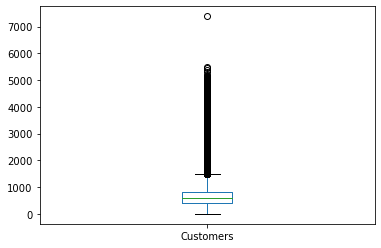

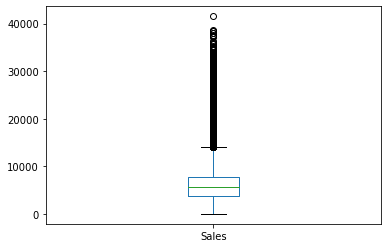

In [15]:
data["Customers"].plot(kind="box")
plt.show()
data["Sales"].plot(kind="box")
plt.show()

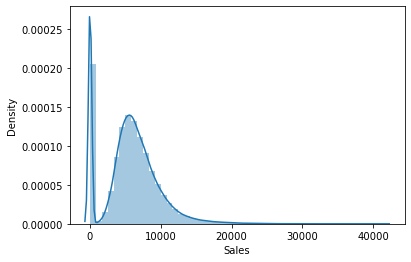

In [16]:
sns.distplot(data["Sales"]) # Right Skewed

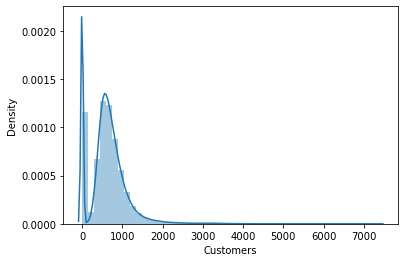

In [17]:
sns.distplot(data["Customers"])

### Categorical (Univariate)

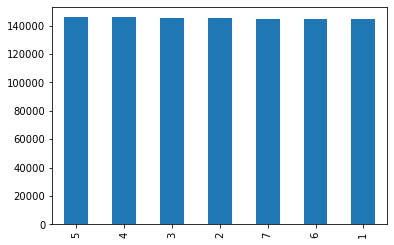

In [18]:
data["DayOfWeek"].value_counts().plot(kind='bar')

In [19]:
print("total sales value",data.Store.shape)
print("Number of unique values",data.Store.nunique())

total sales value (1017209,)
Number of unique values 1115


In [20]:
data["Store"].value_counts().value_counts() 
# there are certain missing values(lesser values)

942    934
758    180
941      1
Name: Store, dtype: int64

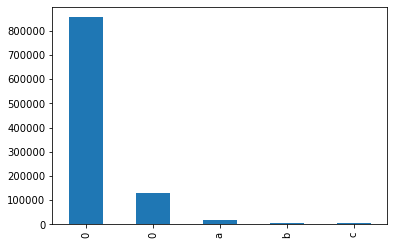

In [21]:
data["StateHoliday"].value_counts().plot(kind='bar')
# Need to modify the data for better interpretation

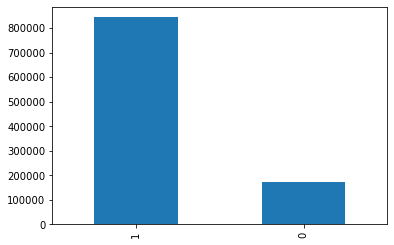

In [22]:
data["Open"].value_counts().plot(kind='bar') #Stores are opened most

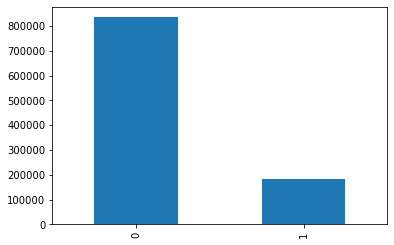

In [23]:
data["SchoolHoliday"].value_counts().plot(kind='bar')

In [24]:
print("stores are closed sales are  " ,data[data['Open']==0]["Sales"].value_counts())
# When store is closed the sales are zero
print("State Holidays are closed sales are  " ,data[data['StateHoliday']=='a']["Sales"].value_counts()[:10])
print("Public Holidays are closed sales are  " ,data[data['SchoolHoliday']==0]["Sales"].value_counts()[:10])
# But during the state holiday, school holiday there are few sales happening in the stores

stores are closed sales are   0    172817
Name: Sales, dtype: int64
State Holidays are closed sales are   0        19566
6116         2
8365         2
5662         2
7739         2
4089         2
7488         2
2401         2
7693         2
10017        2
Name: Sales, dtype: int64
Public Holidays are closed sales are   0       154595
5674       175
6214       164
5558       160
6052       160
5824       157
5197       157
5665       155
5945       154
5041       154
Name: Sales, dtype: int64


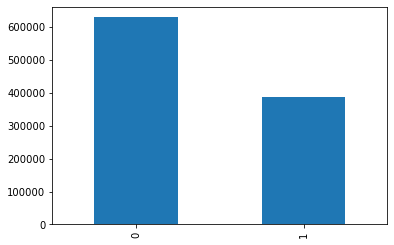

In [25]:
data["Promo"].value_counts().plot(kind='bar')

In [26]:
print("When the promo is given then the sales are ", data[data['Promo']==1]['Sales'].sum())
print("No promo then the sales are",  data[data['Promo']==0]['Sales'].sum())

When the promo is given then the sales are  3101206286
No promo then the sales are 2771974337


### Dates

In [27]:
data['Date'].min(), data['Date'].max() # Date range of Data

('2013-01-01', '2015-07-31')

### Bivariate Analysis

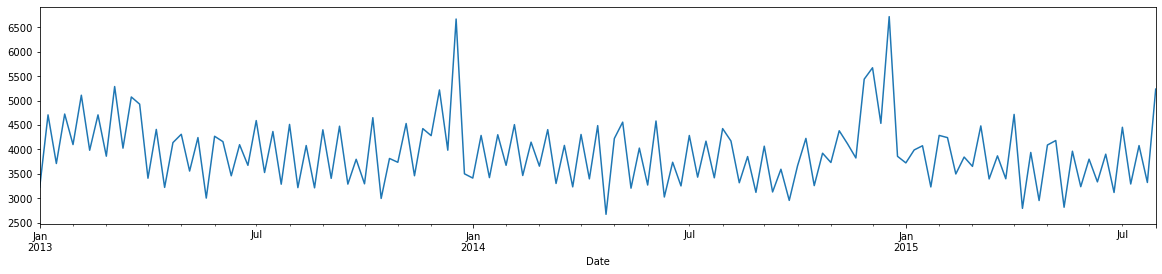

In [28]:
# understand the weekly sales of individual store
store_id =data['Store'].unique()[0]
data['Date']= pd.to_datetime(data["Date"],format="%Y-%m-%d")
store_data =data[data["Store"]==store_id]
store_data.resample(on='Date', rule='1w')["Sales"].mean().plot.line(figsize=(20,4))
#For store 1

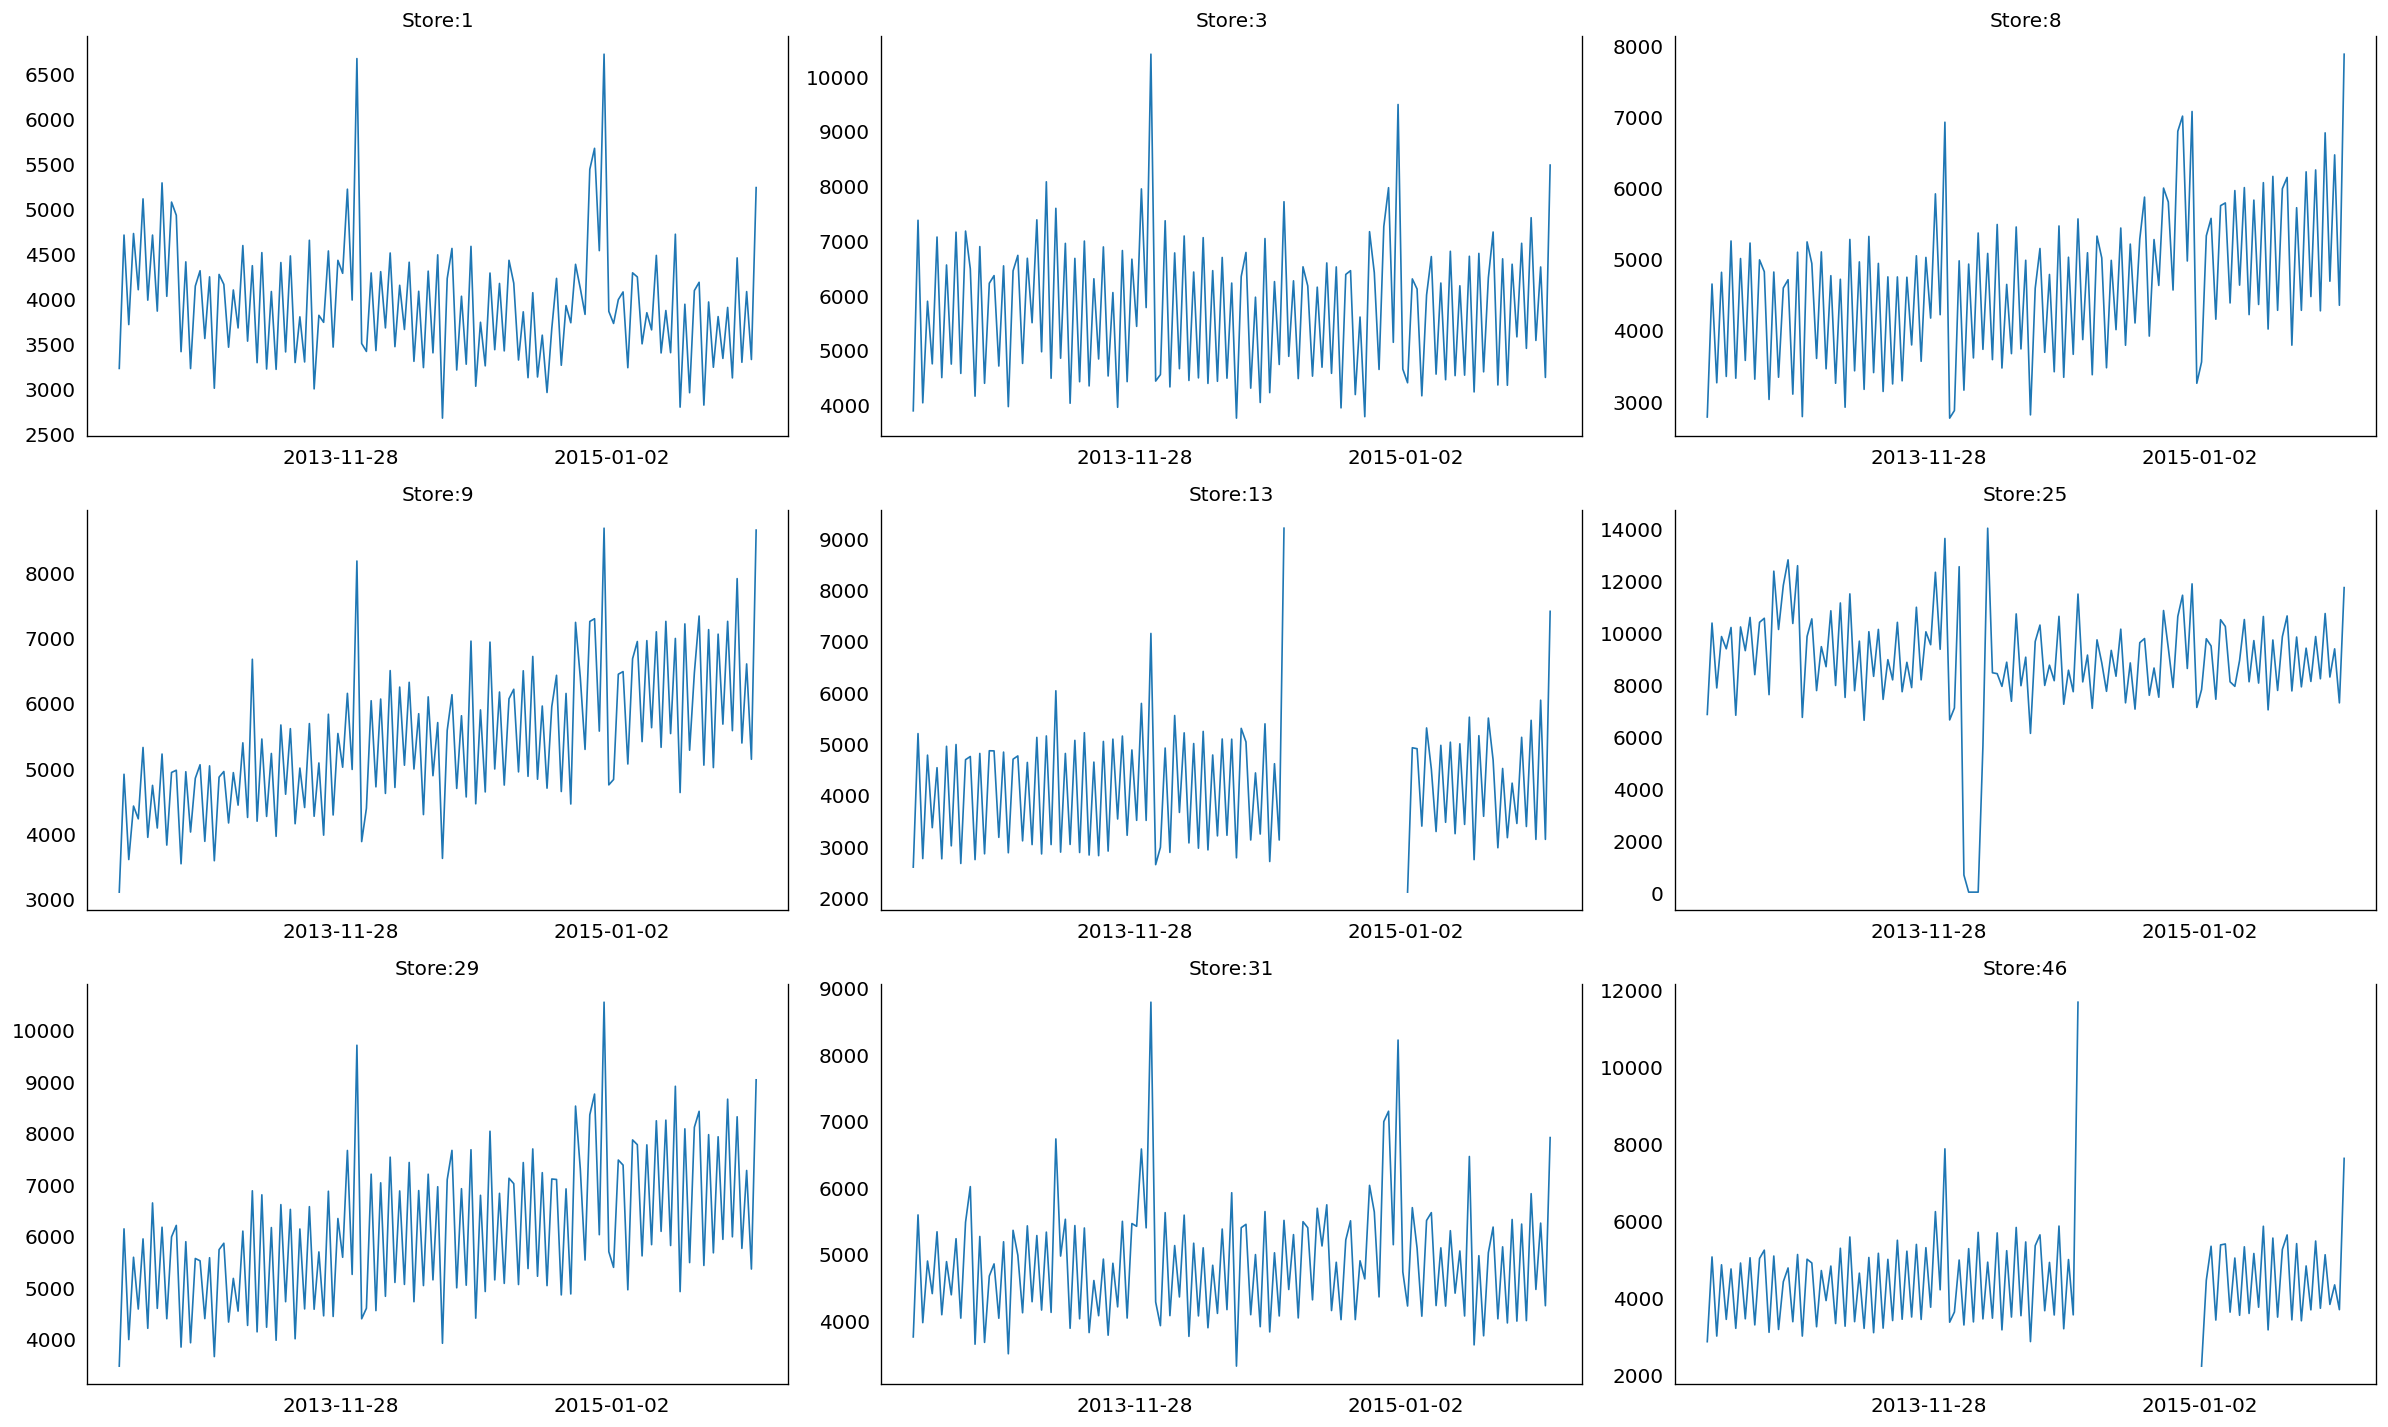

In [29]:
store_id=[1,3,8,9,13,25,29,31,46]
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(20,12))
for i, ax in enumerate(axes.flatten()):
        store_data =data[data["Store"]==store_id[i]]
        store_data_final = store_data.resample(on='Date', rule='1w')["Sales"].mean()
        ax.plot(store_data_final, linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title('Store:' + str(store_id[i]))
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [30]:
## Correlation Analysis
abs(data.corr()).style.background_gradient(cmap="Greens")

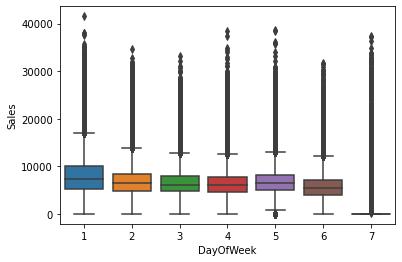

In [31]:
## Box Plot
sns.boxplot(data=data,x="DayOfWeek", y="Sales")

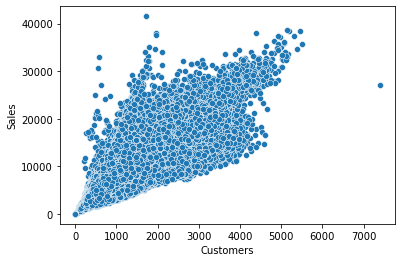

In [32]:
sns.scatterplot(data=data,x="Customers",y="Sales")

In [33]:
data.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [34]:
#setting Date column as index for time series analysis
df = data.set_index('Date')

In [35]:
df

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   
...           ...        ...    ...        ...   ...    ...          ...   
2013-01-01   1111          2      0          0     0      0            a   
2013-01-01   1112          2      0          0     0      0            a   
2013-01-01   1113          2      0          0     0      0            a   
2013-01-01   1114          2      0          0     0      0            a   
2013-01-01   1115          2      0          0     0      0            a   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
...                   ...  
2013-01-01              1  
2013-01-01              1  
2013-01-01              1  
2013-01-01              1  
2013-01-01              1  

[1017209 rows x 8 columns]

- Sales and Customers are main variables whose lag values we will use to predict the sales. 
- We will use Store column to filter Stores for analysis
- Promo, StateHoliday, SchoolHoliday are exogenous variables 

In [36]:
#StateHoliday column is a categorical variable but has 0 and O coumns of same name
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df['StateHoliday']=df['StateHoliday'].map({
        "0":'None',0:'None','a':'Public','b':'Easter','c':'Christmas'
        })

In [37]:
data_df = pd.get_dummies(df, columns=['StateHoliday'], prefix=['StateHoliday'])

In [38]:
data_df['Holiday_Sunday'] = data_df['DayOfWeek'].apply(lambda x: 1 if x==7 else 0)

In [39]:
data_df

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2015-07-31      1          5   5263        555     1      1              1   
2015-07-31      2          5   6064        625     1      1              1   
2015-07-31      3          5   8314        821     1      1              1   
2015-07-31      4          5  13995       1498     1      1              1   
2015-07-31      5          5   4822        559     1      1              1   
...           ...        ...    ...        ...   ...    ...            ...   
2013-01-01   1111          2      0          0     0      0              1   
2013-01-01   1112          2      0          0     0      0              1   
2013-01-01   1113          2      0          0     0      0              1   
2013-01-01   1114          2      0          0     0      0              1   
2013-01-01   1115          2      0          0     0      0              1   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2015-07-31                       0                    0                  1   
2015-07-31                       0                    0                  1   
2015-07-31                       0                    0                  1   
2015-07-31                       0                    0                  1   
2015-07-31                       0                    0                  1   
...                            ...                  ...                ...   
2013-01-01                       0                    0                  0   
2013-01-01                       0                    0                  0   
2013-01-01                       0                    0                  0   
2013-01-01                       0                    0                  0   
2013-01-01                       0                    0                  0   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2015-07-31                    0               0  
2015-07-31                    0               0  
2015-07-31                    0               0  
2015-07-31                    0               0  
2015-07-31                    0               0  
...                         ...             ...  
2013-01-01                    1               0  
2013-01-01                    1               0  
2013-01-01                    1               0  
2013-01-01                    1               0  
2013-01-01                    1               0  

[1017209 rows x 12 columns]

# User defined Functions

In [40]:
#Function to perform Augmented Dickey-Fuller test and print the results
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [41]:
#Function to print the output of the johansen cointegration test
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [42]:
def remove_outliers(store_data):
    # Remove the outliers above 99.9% percentiles

    cols = ['Sales', 'Customers']

    outlier = pd.DataFrame()

    # Get the 99.9% percentiles first
    for col in cols:
        colname = col+'_max'
        # Delete only those outliers which are above 99.9% percentile
        outlier.loc[0, colname] = store_data[col].quantile(0.99)

    # Now delete outliers from the dataframe
    for col in cols:
        # Delete outliers at the upper end
        store_data = store_data[store_data[col] < outlier.loc[0, col+'_max']]

    print(store_data.shape)
    return store_data

In [43]:
#Function to remove outliers and replace them with Nan values
def make_outliers_nan(store_data):    
    # Remove the outliers above 99.9%  percentiles
    cols = ['Sales']

    outlier = pd.DataFrame()

    # Get the 99.9% percentiles first
    for col in cols:
        colname = col+'_max'
        # Get those outliers which are above 99.9% percentile
        outlier.loc[0, colname] = store_data[col].quantile(0.99)
        outlier_rows = store_data[store_data[col] >= outlier.loc[0, col+'_max']][cols].index
        #assigning NaN values to those outliers
        store_data.loc[outlier_rows, ['Sales']] = np.nan

    print(store_data.shape)
    return store_data, outlier_rows

In [44]:
#Function for preprocessing data
def data_preprocessing(store_data):    
    store_data['Open'] = pd.to_numeric(store_data['Open'], errors='coerce').fillna(0)
    store_data['Promo'] = pd.to_numeric(store_data['Promo'], errors='coerce').fillna(0)
    store_data['SchoolHoliday'] = pd.to_numeric(store_data['SchoolHoliday'], errors='coerce').fillna(0)
    store_data['StateHoliday_Christmas'] = pd.to_numeric(store_data['StateHoliday_Christmas'], errors='coerce').fillna(0)
    store_data['StateHoliday_Easter'] = pd.to_numeric(store_data['StateHoliday_Easter'], errors='coerce').fillna(0)
    store_data['StateHoliday_None'] = pd.to_numeric(store_data['StateHoliday_None'], errors='coerce').fillna(0)
    store_data['StateHoliday_Public'] = pd.to_numeric(store_data['StateHoliday_Public'], errors='coerce').fillna(0)
    store_data['Holiday_Sunday'] = pd.to_numeric(store_data['Holiday_Sunday'], errors='coerce').fillna(0)
    return store_data

#Function to print series decomposition plots
def series_decomposition(series):
    rcParams['figure.figsize'] = 12, 8
    decomposition = sm.tsa.seasonal_decompose(series, model='additive') # additive seasonal index
    fig = decomposition.plot()
    plt.show()

#Function to perform data standardization    
def data_standardization(train, test):    
    # Apply standardization scaling
    scaler = StandardScaler()

    # Apply scaler() to all the columns
    scaler.fit(train)
    train = scaler.transform(train)

    # Apply the scaler to the test data set too
    test = scaler.transform(test)

    return train, test, scaler

#Function to Perform a train-test split
def data_split(nobs, df):
    
    train, test = df[0:-nobs], df[-nobs:]

    # Check size
    print(train.shape) 
    print(test.shape) 
    return train, test

#Function to print the Train-Test-Prediction comparison plot
def show_testVsPred_plot(train, test, predictions):    
    plt.figure(figsize=(12,6))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='VAR/VARMAX')
    plt.legend(loc='best')
    plt.title('VAR Model - Investment')
    plt.show()

In [45]:
#Function to perform Granger's cointegration test on Dataset
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    

    maxlag = 12
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = y_true[y_true!=0]
    y_pred = y_pred.loc[y_true.index]
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
#Making MAPE dataframe for storing final results
final_results = pd.DataFrame(columns=['Store', 'MAPE'])

## Storewise Time series Analysis

# Store 1 Analysis and Prediction

In [48]:
#Get store specific data
df_store1 = data_df[data_df['Store']==1]
df_store1 = df_store1.sort_index()
df_store1.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01      1          2      0          0     0      0              1   
2013-01-02      1          3   5530        668     1      0              1   
2013-01-03      1          4   4327        578     1      0              1   
2013-01-04      1          5   4486        619     1      0              1   
2013-01-05      1          6   4997        635     1      0              1   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

### Outliers Treatment

- Values beyond 99.9% percentiles shall be removed

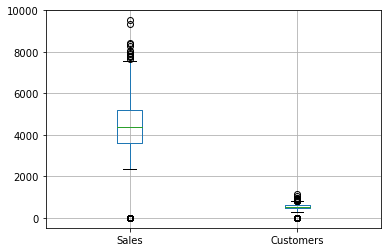

In [49]:
df_store1[['Sales', 'Customers']].boxplot()

In [50]:
df_store1.shape

(942, 12)

In [51]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store1, outlier_rows = make_outliers_nan(df_store1)

(942, 12)


In [52]:
#We assigned NaN to all the outlier,  values of Sales
df_store1.loc[outlier_rows][['Sales', 'Customers']]

Sales  Customers
Date                        
2013-05-31    NaN        795
2013-12-16    NaN        825
2013-12-18    NaN        828
2013-12-20    NaN        895
2013-12-21    NaN        927
2013-12-23    NaN       1130
2014-12-15    NaN        871
2014-12-20    NaN        962
2014-12-22    NaN       1080
2014-12-23    NaN        957

In [53]:
#Interpolating null values instead of deleting
df_store1.interpolate(method='linear', inplace=True)

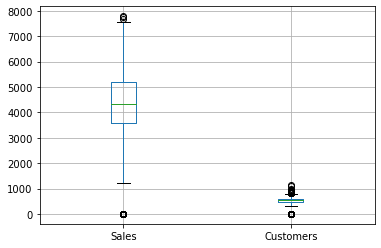

In [54]:
df_store1[['Sales', 'Customers']].boxplot()

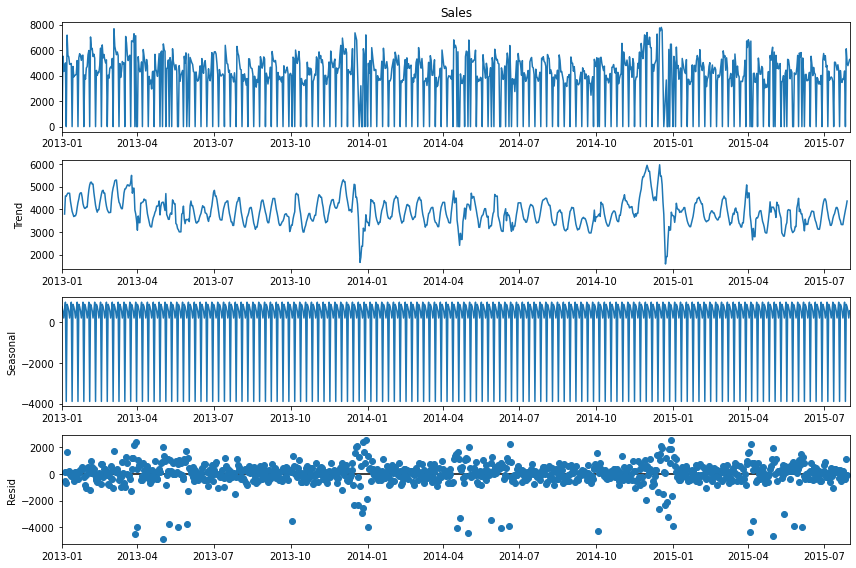

In [55]:
series_decomposition(df_store1['Sales'])

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

### Splitting the Data into Training and Testing Sets

 Perform a train-test split

In [56]:
#Perform a train-test split
nobs = 42
store1_train, store1_test = data_split(nobs, df_store1)

(900, 12)
(42, 12)


In [57]:
#Standardizing data before modelling
store1_train[['Sales_std', 'Customers_std']], store1_test[['Sales_std', 'Customers_std']], scaler_store1 = data_standardization(store1_train[['Sales', 'Customers']], store1_test[['Sales', 'Customers']])
store1_train[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
Date                                
2013-01-01  -1.968016      -2.034421
2013-01-02   0.823860       0.862327
2013-01-03   0.216513       0.472047
2013-01-04   0.296786       0.649841
2013-01-05   0.554769       0.719224

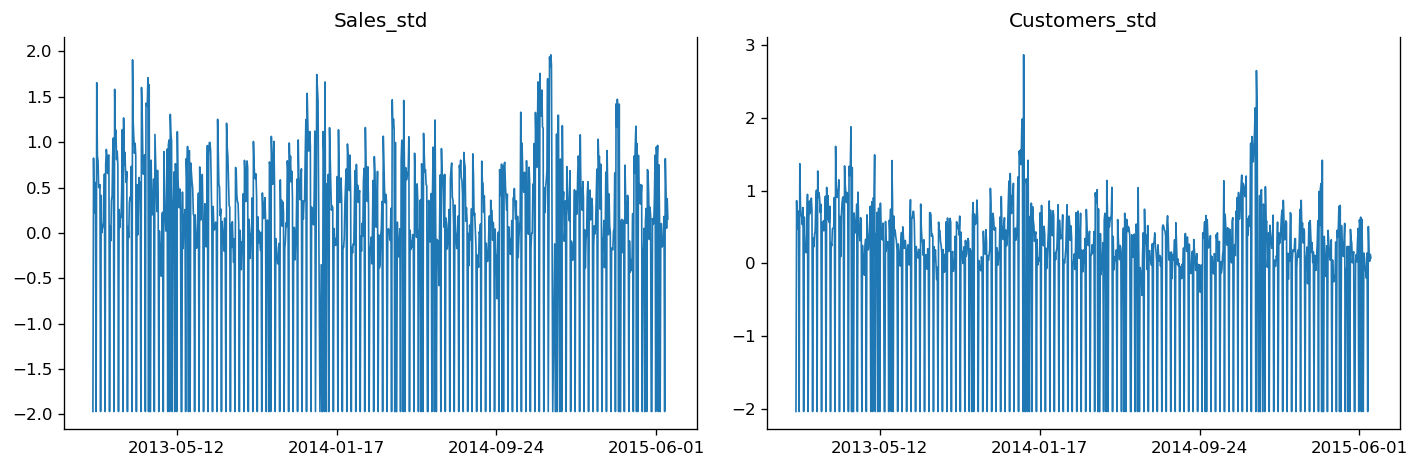

In [58]:
# Plot
ls=['Sales_std','Customers_std']
df=store1_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,4))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # Decorations
        ax.set_title(df.columns[i])
        ax.spines["top"].set_alpha(0)
        
plt.tight_layout();

In [59]:
# ADF Test on each column
for name, column in store1_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8666
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6017
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0057. Rejecting Null Hypothesis.
 => Series is Stationary.




#### Both Sales and Customers series are stationary so we can go ahead and train our VAR/VARMAX models

In [60]:
#Searching for the best hyperparameter values for our VAR/VARMAX models
#Note that j can take 0 value which is basically VAR Model using VARMAX function
exog = store1_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,5]:
    for j in [0,1,5]:
        mod = VARMAX(store1_train[['Sales_std', 'Customers_std']], order=(i,j),trend='c', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model 

Lag Order = 1 0
AIC :  1016.499884553308
BIC :  1126.9549641097672
HQIC:  1058.6945217313364 

Lag Order = 1 1
AIC :  804.9109011167752
BIC :  934.5755597265317
HQIC:  854.4437360648956 

Lag Order = 1 5
AIC :  615.3159640446966
BIC :  821.8189388676419
HQIC:  694.2015900731844 

Lag Order = 5 0
AIC :  685.0980388223234
BIC :  872.3914345919715
HQIC:  756.6454670807193 

Lag Order = 5 1
AIC :  571.0861699861962
BIC :  777.5891448091415
HQIC:  649.9717960146841 

Lag Order = 5 5
AIC :  389.45580774125057
BIC :  672.7970987773849
HQIC:  497.694224850106 



Order 5,5 gave out the lowest AIC value so we will build our model using that

In [61]:
#getting our exogenous variables 
exog = store1_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
#training our VARMAX model with selected order values
mod_store1 = VARMAX(store1_train[['Sales_std', 'Customers_std']], order=(5,5),trend='c', exog=exog)
res_store1 = mod_store1.fit(maxiter=1000, disp=False)

#Test predictions
exog = store1_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_store1 = res_store1.forecast(steps= 42, exog=exog)
predictions_store1.index = store1_test.index
predictions_store1.head()

Sales_std  Customers_std
Date                                
2015-06-20   0.185624       0.208189
2015-06-21  -2.235328      -2.389015
2015-06-22   0.030236       0.173739
2015-06-23  -0.111126      -0.098884
2015-06-24  -0.104530       0.031234

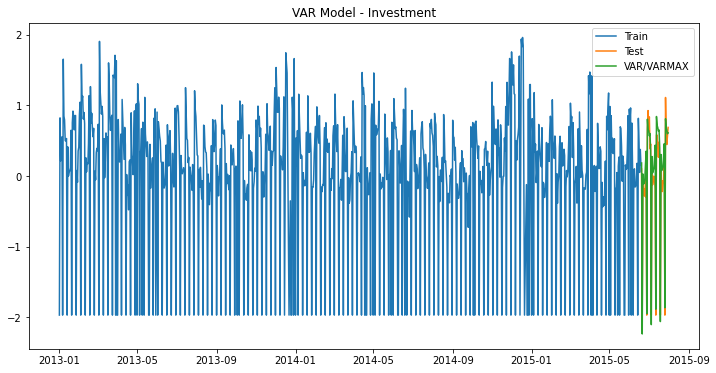

In [62]:
#plotting Train, Test and VARMAX
show_testVsPred_plot(store1_train['Sales_std'], store1_test['Sales_std'], predictions_store1['Sales_std'])

In [63]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store1_test['Sales_std'], predictions_store1['Sales_std']))
print(rmse)

0.22501271095980233


In [64]:
#converting standardized values back to orignal form
actual_store1 = pd.DataFrame(scaler_store1.inverse_transform(store1_test[['Sales_std', 'Customers_std']]))[0]
predicted_store1 = pd.DataFrame(scaler_store1.inverse_transform(predictions_store1[['Sales_std', 'Customers_std']]))[0]
#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store1, predicted_store1], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual    Predicted
0  4097.0  4265.815787
1     0.0  -529.477534
2  3846.0  3958.031513
3  3762.0  3678.030338
4  3346.0  3691.095057
5  3533.0  3827.892381
6  3317.0  4217.835050
7  4019.0  4595.893506
8     0.0    36.381824
9  5197.0  5493.770308

In [65]:
sqrt(mean_squared_error(actual_store1,predicted_store1))

445.69328471022703

In [66]:
#MAPE value without 0 sales values
mape_store1 = mean_absolute_percentage_error(actual_store1, predicted_store1)

In [67]:
final_results = final_results.append({'Store':'Store1', 'MAPE':mape_store1},ignore_index=True)
final_results

Store      MAPE
0  Store1  9.482873

## Result Analysis:-
    - We can see that from the predicted vs Actual values that the predicted values came out to be very close to each other. The rows where actual Sales were 0, our model has predicted a value close to 0
    - We can consider low values of Sales as an indictor that there will be close to none, i.e., 0 sales on that particular day
    - For this store, I have predicted Sales for the next 42 days which is 6 weeks prediction as required.

# Store 3 Analysis and Prediction

In [68]:
#Get store specific data
df_store3 = data_df[data_df['Store']==3]
df_store3 = df_store3.sort_index()

df_store3.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01      3          2      0          0     0      0              1   
2013-01-02      3          3   6823        805     1      0              1   
2013-01-03      3          4   5902        721     1      0              1   
2013-01-04      3          5   6069        690     1      0              1   
2013-01-05      3          6   4523        525     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

### Outliers Treatment

- Values beyond 99.9% percentiles shall be removed

(942, 12)

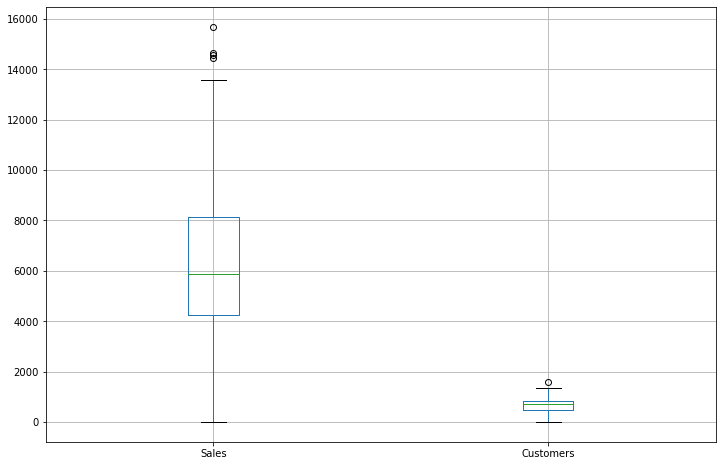

In [69]:
#Values beyond 99.9% and 0.01% percentiles shall be removed
df_store3[['Sales', 'Customers']].boxplot()
df_store3.shape

In [70]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store3, outlier_rows = make_outliers_nan(df_store3)

(942, 12)


In [71]:
#We assigned NaN to all the outlier,  values of Sales
df_store3.loc[outlier_rows][['Sales', 'Customers']]

Sales  Customers
Date                        
2013-12-16    NaN       1282
2013-12-17    NaN       1284
2013-12-18    NaN       1198
2013-12-20    NaN       1227
2013-12-23    NaN       1579
2014-03-31    NaN       1161
2014-06-30    NaN       1193
2014-12-15    NaN       1115
2014-12-16    NaN       1204
2015-06-30    NaN       1072

In [72]:
#Interpolating null values instead of deleting
df_store3.interpolate(method='linear', inplace=True)

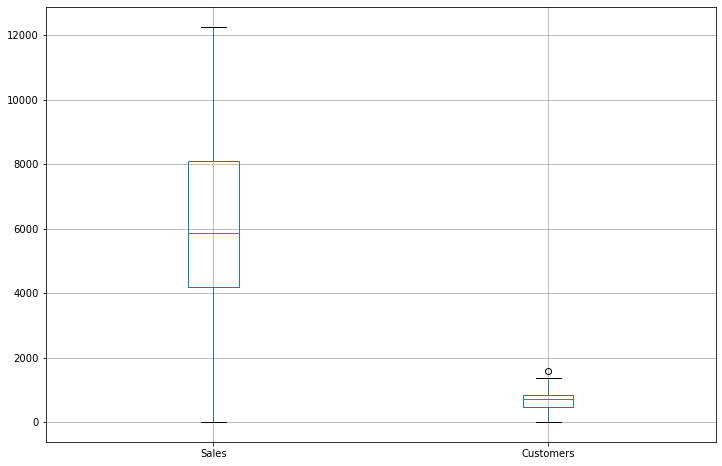

In [73]:
df_store3[['Sales', 'Customers']].boxplot()

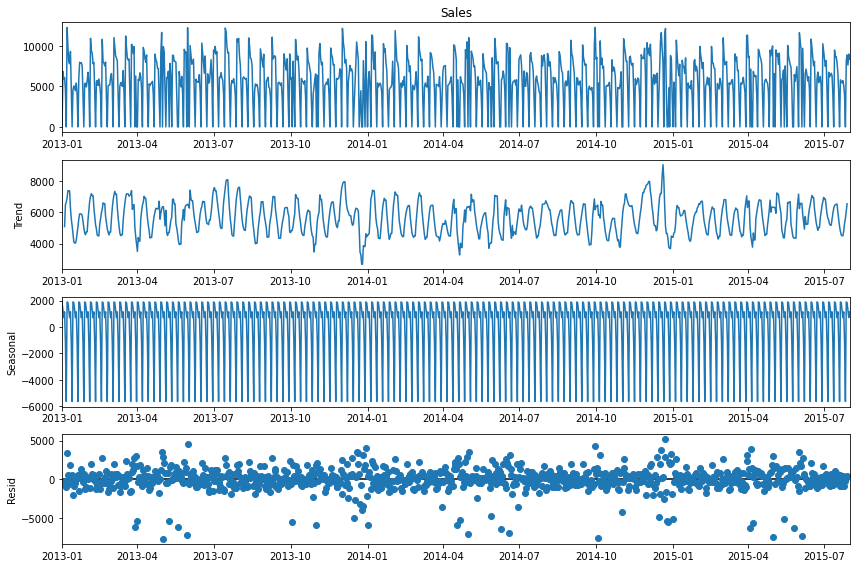

In [74]:
series_decomposition(df_store3['Sales'])

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

### Splitting the Data into Training and Testing Sets

In [75]:
#Perform a train-test split
nobs = 42
store3_train, store3_test = data_split(nobs, df_store3)

(900, 12)
(42, 12)


In [76]:
#Standardizing data before modelling
store3_train[['Sales_std', 'Customers_std']], store3_test[['Sales_std', 'Customers_std']], scaler_store3 = data_standardization(store3_train[['Sales', 'Customers']], store3_test[['Sales', 'Customers']])
store3_train[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
Date                                
2013-01-01  -1.756192      -1.911123
2013-01-02   0.365395       0.563704
2013-01-03   0.079013       0.305461
2013-01-04   0.130941       0.210157
2013-01-05  -0.349782      -0.297106

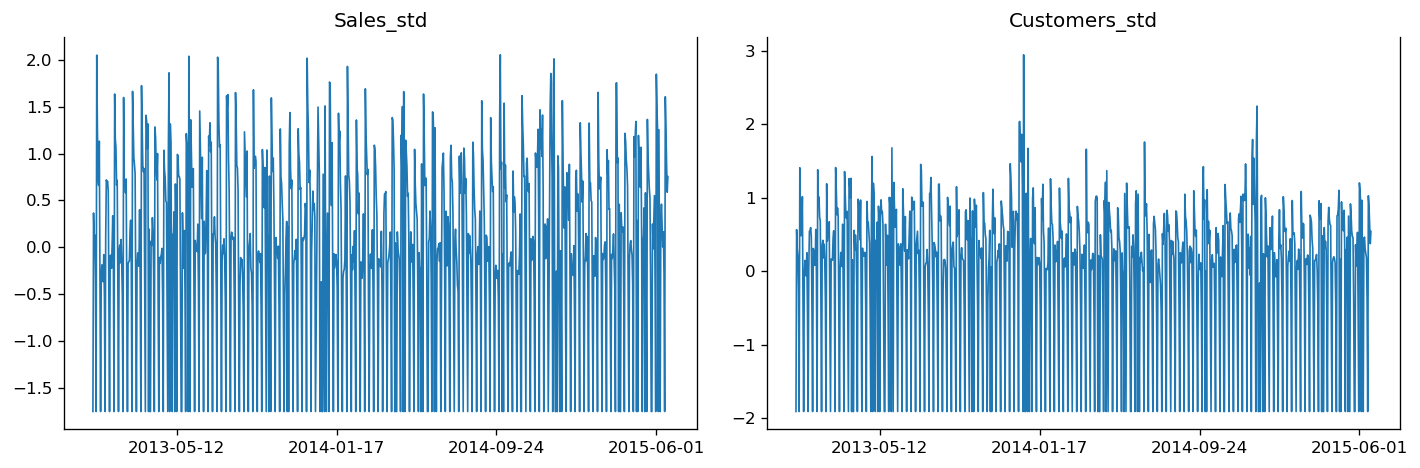

In [77]:
# Plot
ls=['Sales_std','Customers_std']
df=store3_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,4))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # Decorations
        ax.set_title(df.columns[i])
        ax.spines["top"].set_alpha(0)
        
plt.tight_layout();

In [78]:
# ADF Test on each column
for name, column in store3_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.414
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4562
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




#### Both Sales and Customers series are stationary so we can go ahead and train our VAR/VARMAX models

In [79]:
#Searching for the best hyperparameter values for our VAR/VARMAX models
#Note that j can take 0 value which is basically VAR Model using VARMAX function
exog = store3_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,5]:
    for j in [0,1,5]:
        mod = VARMAX(store3_train[['Sales_std', 'Customers_std']], order=(i,j),trend='c', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model 

Lag Order = 1 0
AIC :  759.2834142165832
BIC :  869.7384937730424
HQIC:  801.4780513946116 

Lag Order = 1 1
AIC :  659.1546568745088
BIC :  788.8193154842652
HQIC:  708.6874918226291 

Lag Order = 1 5
AIC :  569.4496330219587
BIC :  775.952607844904
HQIC:  648.3352590504466 

Lag Order = 5 0
AIC :  702.255553532946
BIC :  889.5489493025941
HQIC:  773.8029817913421 

Lag Order = 5 1
AIC :  594.9844864875027
BIC :  801.4874613104481
HQIC:  673.8701125159906 

Lag Order = 5 5
AIC :  420.71407101653324
BIC :  704.0553620526675
HQIC:  528.9524881253888 



Order 5,5 gave out the lowest AIC value so we will build our model using that

In [80]:
#getting our exogenous variables 
exog = store3_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
#training our VARMAX model with selected order values
mod_store3 = VARMAX(store3_train[['Sales_std', 'Customers_std']], order=(5,5),trend='c', exog=exog)
res_store3 = mod_store3.fit(maxiter=1000, disp=False)

#Test predictions
exog = store3_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_store3 = res_store3.forecast(steps= 42, exog=exog)
predictions_store3.index = store3_test.index
predictions_store3.head()

Sales_std  Customers_std
Date                                
2015-06-20  -0.378531      -0.417117
2015-06-21  -1.791374      -2.008264
2015-06-22   0.035060       0.156481
2015-06-23  -0.066294       0.104496
2015-06-24  -0.027386       0.223205

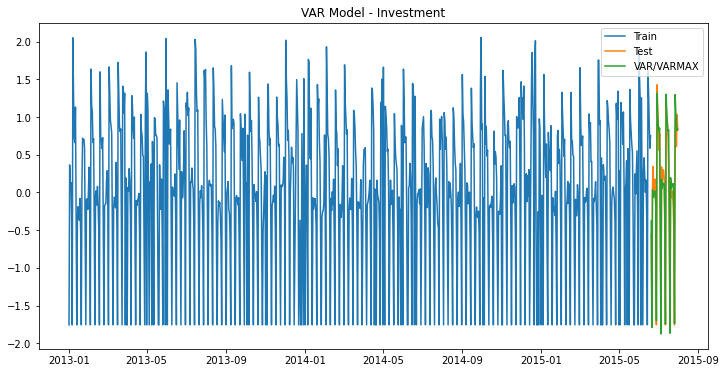

In [81]:
#plotting Train, Test and VARMAX
show_testVsPred_plot(store3_train['Sales_std'], store3_test['Sales_std'], predictions_store3['Sales_std'])

In [82]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store3_test['Sales_std'], predictions_store3['Sales_std']))
print(rmse)


0.1892187158196158


In [83]:
#converting standardized values back to orignal form
actual_store3 = pd.DataFrame(scaler_store3.inverse_transform(store3_test[['Sales_std', 'Customers_std']]))[0]
predicted_store3 = pd.DataFrame(scaler_store3.inverse_transform(predictions_store3[['Sales_std', 'Customers_std']]))[0]
#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store3, predicted_store3], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual    Predicted
0   3891.0  4430.543126
1      0.0  -113.142325
2   5840.0  5760.645473
3   6757.0  5434.693189
4   5448.0  5559.820549
5   5763.0  5598.065666
6   6222.0  5706.896939
7   5156.0  5082.486868
8      0.0   175.561344
9  10243.0  9869.558930

In [84]:
sqrt(mean_squared_error(actual_store3,predicted_store3))

608.5251890353811

In [85]:
#MAPE value without 0 sales values
mape_store3 = mean_absolute_percentage_error(actual_store3, predicted_store3)

In [86]:
final_results = final_results.append({'Store':'Store3', 'MAPE':mape_store3},ignore_index=True)
final_results

Store      MAPE
0  Store1  9.482873
1  Store3  8.148553

## Result Analysis:-
    - We can see that from the predicted vs Actual values that the predicted values came out to be very close to each other. The rows where actual Sales were 0, our model has predicted a value close to 0
    - We can consider low values of Sales as an indictor that there will be close to none, i.e., 0 sales on that particular day
    - For this store, I have predicted Sales for the next 42 days which is 6 weeks prediction as required.

# Store 8 Analysis and Prediction

In [87]:
#Get store specific data
df_store8 = data_df[data_df['Store']==8]
df_store8 = df_store8.sort_index()

df_store8.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01      8          2      0          0     0      0              1   
2013-01-02      8          3   5419        698     1      0              1   
2013-01-03      8          4   4842        662     1      0              1   
2013-01-04      8          5   4059        517     1      0              1   
2013-01-05      8          6   2337        312     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

### Outliers Treatment

- Values beyond 99.9% percentiles shall be removed

In [88]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store8, outlier_rows = make_outliers_nan(df_store8)

(942, 12)


In [89]:
#We assigned NaN to all the outlier,  values of Sales
df_store8.loc[outlier_rows][['Sales', 'Customers']]

Sales  Customers
Date                        
2013-12-16    NaN       1001
2014-10-06    NaN       1027
2014-12-01    NaN       1043
2014-12-15    NaN       1014
2015-04-02    NaN       1133
2015-04-27    NaN       1004
2015-04-30    NaN       1080
2015-06-01    NaN       1012
2015-06-15    NaN        938
2015-06-29    NaN        945

In [90]:
#Interpolating null values instead of deleting
df_store8.interpolate(method='linear', inplace=True)

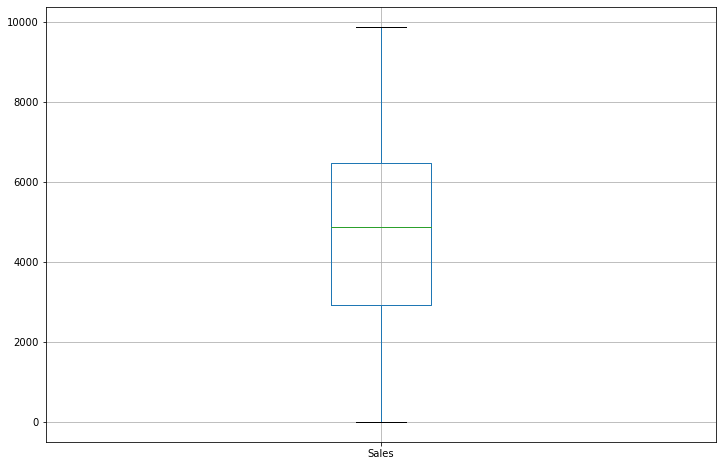

In [91]:
df_store8[['Sales']].boxplot()

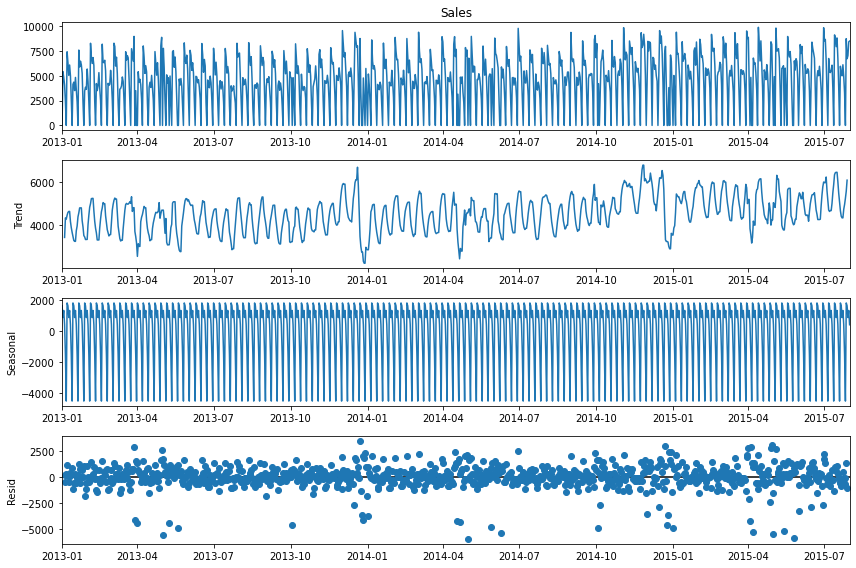

In [92]:
series_decomposition(df_store8['Sales'])

### Building model to predict Sales
- First preprocess the store specific data
- Check stationarity 
- Build Model

### Splitting the Data into Training and Testing Sets

In [93]:
#Perform a train-test split
nobs = 42
store8_train, store8_test = data_split(nobs, df_store8)

(900, 12)
(42, 12)


In [94]:
#Standardizing data before modelling
store8_train[['Sales_std', 'Customers_std']], store8_test[['Sales_std', 'Customers_std']], scaler_store8 = data_standardization(store8_train[['Sales', 'Customers']], store8_test[['Sales', 'Customers']])
store8_train[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
Date                                
2013-01-01  -1.724515      -1.860670
2013-01-02   0.348238       0.522844
2013-01-03   0.127537       0.399912
2013-01-04  -0.171958      -0.095231
2013-01-05  -0.830618      -0.795260

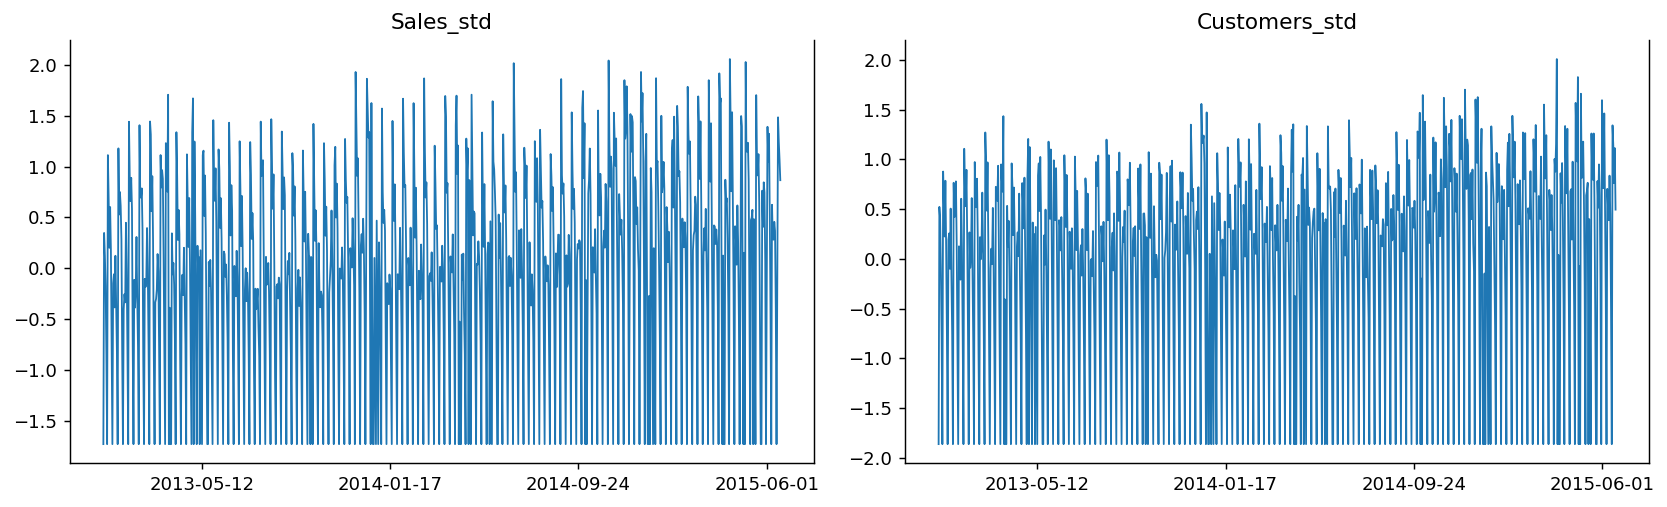

In [95]:
# Plot
ls=['Sales_std','Customers_std']
df=store8_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=130, figsize=(13,4))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # Decorations
        ax.set_title(df.columns[i])
        ax.spines["top"].set_alpha(0)
        
plt.tight_layout();

In [96]:
# ADF Test on each column
for name, column in store8_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.056
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0011. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8468
 No. Lags Chosen       = 20
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0025. Rejecting Null Hypothesis.
 => Series is Stationary.




### Since both series are stationary, we can train a multivariate VARMAX model

In [97]:
#Searching for the best hyperparameter values for our VAR/VARMAX models
#Note that j can take 0 value which is basically VAR Model using VARMAX function
exog = store8_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,11]:
    for j in [0,7]:
        mod = VARMAX(store8_train[['Sales_std', 'Customers_std']], order=(i,j),trend='c', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model 


Lag Order = 1 0
AIC :  982.9825379866195
BIC :  1093.4376175430787
HQIC:  1025.177175164648 

Lag Order = 1 7
AIC :  463.85493360387784
BIC :  708.7770665334177
HQIC:  557.4169551725495 

Lag Order = 11 0
AIC :  89.36358904556701
BIC :  391.91445913499865
HQIC:  204.94020392451438 

Lag Order = 11 7
AIC :  -106.96908112742454
BIC :  330.0488423350877
HQIC:  59.97491814216613 



Order 11,7 gave out the lowest AIC value so we will build our model using that

In [98]:
#getting our exogenous variables 
exog = store8_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
#training our VARMAX model with selected order values
mod_store8 = VARMAX(store8_train[['Sales_std', 'Customers_std']], order=(11,7),trend='c', exog=exog)
res_store8 = mod_store8.fit(maxiter=1000, disp=False)

#Test predictions
exog = store8_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_store8 = res_store8.forecast(steps= 42, exog=exog)
predictions_store8.index = store8_test.index
predictions_store8.head()

Sales_std  Customers_std
Date                                
2015-06-20  -0.491455      -0.513558
2015-06-21  -1.808600      -1.841395
2015-06-22   0.631799       0.721403
2015-06-23   0.171183       0.359948
2015-06-24   0.104649       0.191038

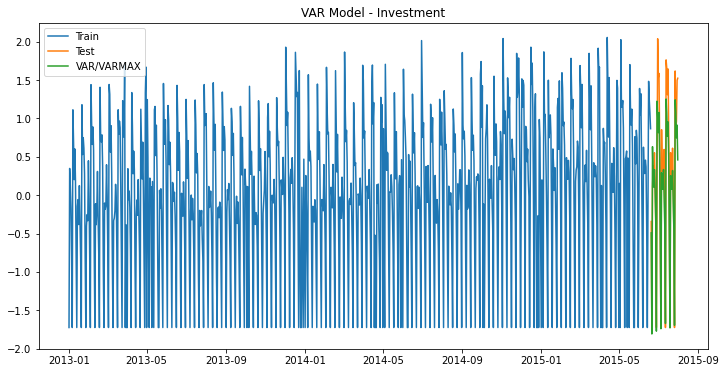

In [99]:
#plotting Train, Test and VARMAX
show_testVsPred_plot(store8_train['Sales_std'], store8_test['Sales_std'], predictions_store8['Sales_std'])

In [100]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store8_test['Sales_std'], predictions_store8['Sales_std']))
print(rmse)

0.43345451182480454


In [101]:
#converting standardized values back to orignal form
actual_store8 = pd.DataFrame(scaler_store8.inverse_transform(store8_test[['Sales_std', 'Customers_std']]))[0]
predicted_store8 = pd.DataFrame(scaler_store8.inverse_transform(predictions_store8[['Sales_std', 'Customers_std']]))[0]
#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store8, predicted_store8], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual    Predicted
0  3611.0  3223.707734
1     0.0  -219.832600
2  4796.0  6160.341281
3  5501.0  4956.106752
4  5005.0  4782.160169
5  5956.0  5377.985553
6  5016.0  4659.489157
7  3611.0  3627.194881
8     0.0  -122.802262
9  4918.0  7709.892049

In [102]:
sqrt(mean_squared_error(actual_store8,predicted_store8))

1133.222306859244

In [103]:
#MAPE value without 0 sales values
mape_store8 = mean_absolute_percentage_error(actual_store8, predicted_store8)

In [104]:
final_results = final_results.append({'Store':'Store8', 'MAPE':mape_store8},ignore_index=True)
final_results

Store       MAPE
0  Store1   9.482873
1  Store3   8.148553
2  Store8  14.954222

## Result Analysis:-
    - We can see that from the predicted vs Actual values that the predicted values came out to be very close to each other. The rows where actual Sales were 0, our model has predicted a value close to 0
    - We can consider low values of Sales as an indictor that there will be close to none, i.e., 0 sales on that particular day
    - For this store, I have predicted Sales for the next 42 days which is 6 weeks prediction as required.

# Store 9 Analysis and Prediction

In [105]:
#Get store specific data
df_store9 = data_df[data_df['Store']==9]
df_store9 = df_store9.sort_index()

df_store9.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01      9          2      0          0     0      0              1   
2013-01-02      9          3   4903        481     1      0              1   
2013-01-03      9          4   4602        453     1      0              1   
2013-01-04      9          5   4798        497     1      0              1   
2013-01-05      9          6   4254        450     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

### Outliers Treatment
- Values beyond 99.9% percentiles shall be removed

(942, 12)

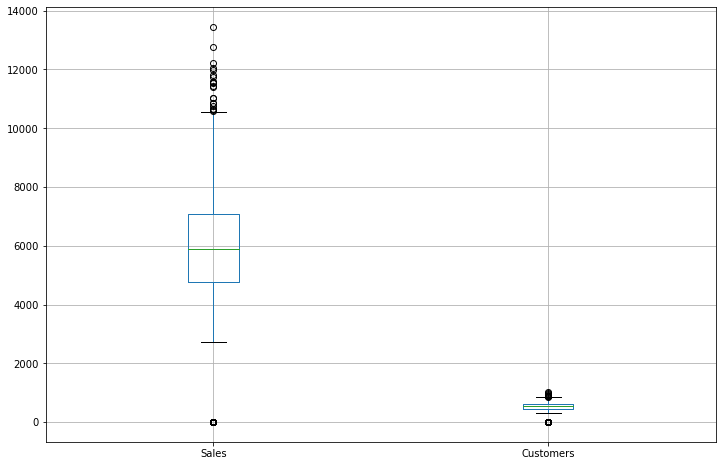

In [106]:
df_store9[['Sales', 'Customers']].boxplot()

df_store9.shape

In [107]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store9, outlier_rows = make_outliers_nan(df_store9)
#We assigned NaN to all the outlier,  values of Sales
df_store9.loc[outlier_rows][['Sales', 'Customers']]

(942, 12)


Sales  Customers
Date                        
2014-06-30    NaN        888
2014-11-03    NaN        894
2014-12-15    NaN        834
2014-12-22    NaN        961
2015-03-30    NaN        795
2015-04-13    NaN        912
2015-04-27    NaN        843
2015-05-04    NaN        889
2015-06-01    NaN        884
2015-06-29    NaN        882

In [108]:
#Interpolating null values instead of deleting
df_store9.interpolate(method='linear', inplace=True)

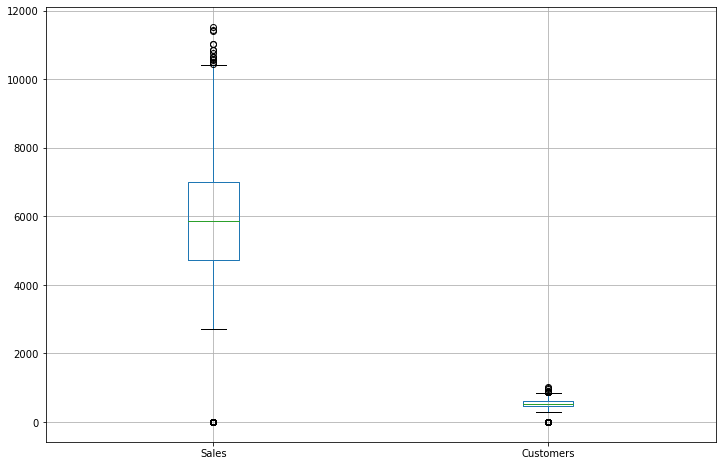

In [109]:
df_store9[['Sales', 'Customers']].boxplot()

### I am sampling daily data to weekly data to make the trend clearer

In [110]:
store9_1w = df_store9.resample('1w').mean()   

store9_1w.shape

(135, 12)

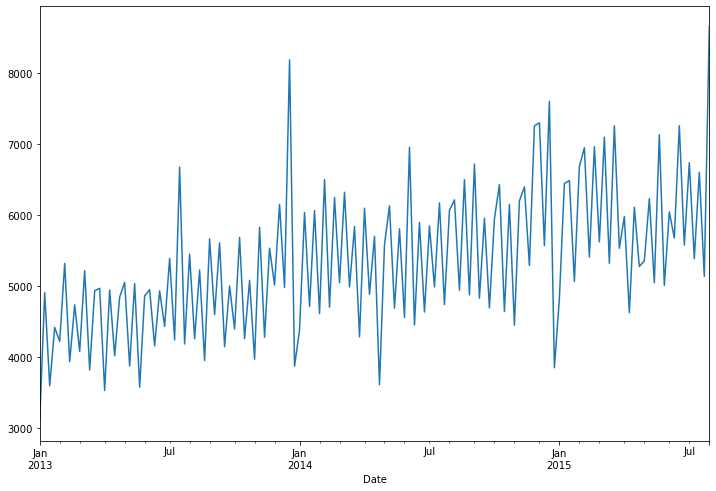

In [111]:
store9_1w['Sales'].plot()

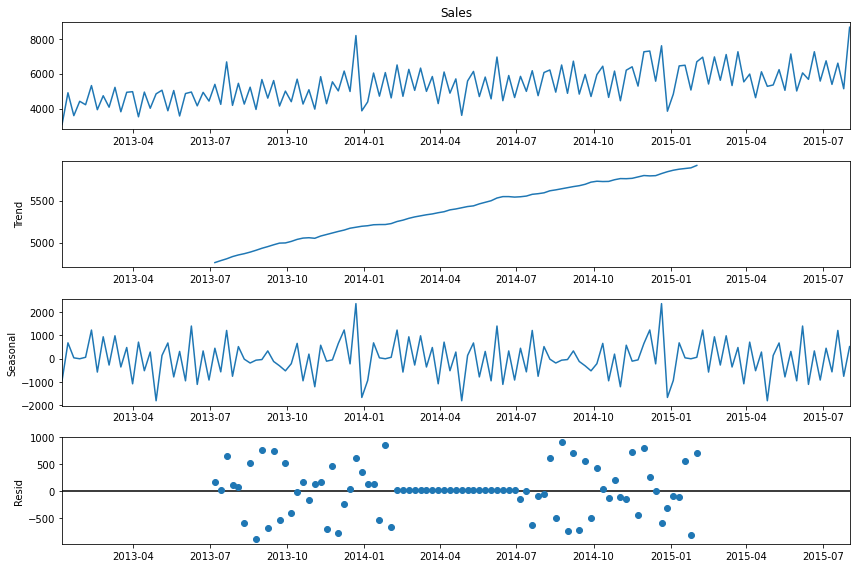

In [112]:
series_decomposition(store9_1w['Sales'])

### We see a clear upward trend in this dataset. We will prepare train and test data to train the model

#### Splitting the Data into Training and Testing Sets and then data standardization

In [113]:
#Perform a train-test split
nobs = 6
store9_train, store9_test = data_split(nobs, store9_1w)

(129, 12)
(6, 12)


In [114]:
#Standardizing data before modelling
store9_train[['Sales_std', 'Customers_std']], store9_test[['Sales_std', 'Customers_std']], scaler_store9 = data_standardization(store9_train[['Sales', 'Customers']], store9_test[['Sales', 'Customers']])
store9_train[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
Date                                
2013-01-06  -2.212827      -2.347368
2013-01-13  -0.401540      -0.682546
2013-01-20  -1.712031      -1.900056
2013-01-27  -0.890314      -1.124716
2013-02-03  -1.086566      -1.414697

In [115]:
# ADF Test on each column
for name, column in store9_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7135
 No. Lags Chosen       = 3
 Critical value 1%     = -3.484
 Critical value 5%     = -2.885
 Critical value 10%    = -2.579
 => P-Value = 0.0717. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4423
 No. Lags Chosen       = 13
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.5618. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




### We can see that Adfuller test showed that both Series and Customers time series are Non-Stationary. 
### We will now perform Johansen Cointegration Test to see if both series are cointegrated or not.

In [116]:
joh_model1 = coint_johansen(store9_train[['Sales_std', 'Customers_std']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0     45.749924   62.858992
1     17.109068   17.109068 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



Trace and maximum eigenvalue Statistics are bigger than its Critical 95% level so we reject the null hypothesis and accept that there exists cointegration. Let's confirm it using Granger Causality Tests

In [117]:
grangers_causation_matrix(store9_train, variables = ['Sales_std', 'Customers_std'])           

Sales_std_x  Customers_std_x
Sales_std_y           1.0000           0.0034
Customers_std_y       0.0013           1.0000

#### We have p values far less than 0.05 so we can reject the Grangers Causality test null hypothesis that x(t) doesn't Granger-cause y(t) means x(t) cause y(t). So, we are now sure that both Sales and Customers time series are Cointegrated

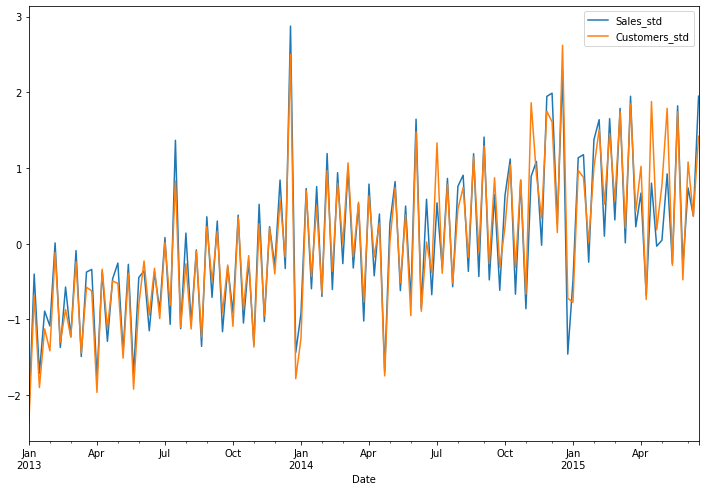

In [118]:
store9_train[['Sales_std', 'Customers_std']].plot()

#### Finally,  the plot shows that Sales and Customers time series are Cointegrated too. So, now we will go ahead and build VAR/VARMAX model

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

In [119]:
#Searching for the best hyperparameter values for our VAR/VARMAX models
#For VAR model, we will take 0 value of j to build VAR model from VARMAX function itself
exog = store9_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,5]:
    for j in [0, 1, 5]:
        mod = VARMAX(store9_train[['Sales_std', 'Customers_std']], order=(i,j),trend='c', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model 

Lag Order = 1 0
AIC :  282.47703101172726
BIC :  348.2527163120457
HQIC:  309.2030235248512 

Lag Order = 1 1
AIC :  196.11596815173203
BIC :  273.33090306949714
HQIC:  227.48995936279056 

Lag Order = 1 5
AIC :  229.44592760762674
BIC :  352.41786099517867
HQIC:  279.41191361042365 

Lag Order = 5 0
AIC :  204.0547996548366
BIC :  315.5874834249418
HQIC:  249.37278695969889 

Lag Order = 5 1
AIC :  205.78070067657103
BIC :  328.75263406412296
HQIC:  255.74668667936794 

Lag Order = 5 5
AIC :  194.67152408068077
BIC :  363.4004559380194
HQIC:  263.229504875216 



Order 5,0 gave out the lowest AIC value so we will build our model using that

In [120]:
#getting our exogenous variables
exog = store9_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
#training our VARMAX model with selected order values
mod_store9 = VARMAX(store9_train[['Sales_std', 'Customers_std']], order=(5,0),trend='c',
             exog=exog[:])
res_store9 = mod_store9.fit(maxiter=1000, disp=False)

#Test predictions
exog = store9_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_store9 = res_store9.forecast(steps= 6, exog=exog)
predictions_store9.index = store9_test.index
predictions_store9.head()

Sales_std  Customers_std
Date                                
2015-06-28   0.246785       0.232927
2015-07-05   1.510661       1.186765
2015-07-12   0.179436       0.043793
2015-07-19   1.515168       1.170426
2015-07-26   0.111246      -0.123181

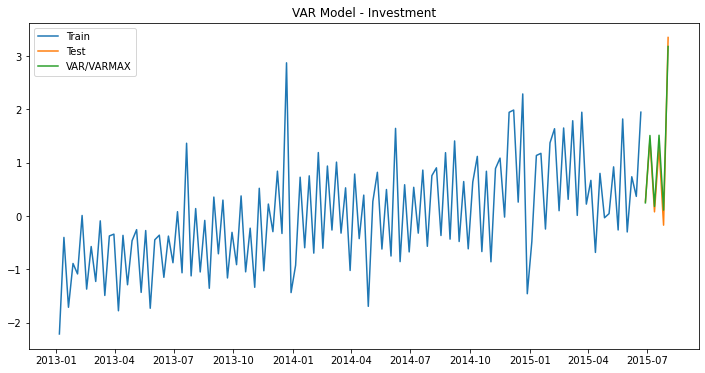

In [121]:
#plotting Train, Test and VARMAX
show_testVsPred_plot(store9_train['Sales_std'], store9_test['Sales_std'], predictions_store9['Sales_std'])

In [122]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store9_test['Sales_std'], predictions_store9['Sales_std']))
print(rmse)

0.1709813262545512


In [123]:
#converting standardized values back to orignal form
actual_store9 = pd.DataFrame(scaler_store9.inverse_transform(store9_test[['Sales_std', 'Customers_std']]))[0]
predicted_store9 = pd.DataFrame(scaler_store9.inverse_transform(predictions_store9[['Sales_std', 'Customers_std']]))[0]

#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store9, predicted_store9], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual    Predicted
0  5573.571429  5552.864643
1  6734.500000  6816.956555
2  5383.857143  5485.504250
3  6599.714286  6821.464134
4  5134.142857  5417.302148
5  8656.000000  8487.016619

In [124]:
sqrt(mean_squared_error(actual_store9,predicted_store9))

171.01050218648683

In [125]:
#MAPE value without 0 sales values
mape_store9 = mean_absolute_percentage_error(actual_store9, predicted_store9)
print(mape_store9)

2.385221385202597


In [126]:
final_results = final_results.append({'Store':'Store9', 'MAPE':mape_store9},ignore_index=True)
final_results

Store       MAPE
0  Store1   9.482873
1  Store3   8.148553
2  Store8  14.954222
3  Store9   2.385221

## Result Analysis:-
    - For this store, I have predicted Sales for the next 6 weeks as required.

# Store 13 Analysis and Prediction

In [127]:
#Get store specific data
df_store13 = data_df[data_df['Store']==13]
df_store13 = df_store13.sort_index()

df_store13.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01     13          2      0          0     0      0              1   
2013-01-02     13          3   3737        317     1      0              1   
2013-01-03     13          4   3674        292     1      0              1   
2013-01-04     13          5   3848        340     1      0              1   
2013-01-05     13          6   4285        344     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

In [128]:
#dataset has many missing values. It should have 942 rows but have only 758 means 184 rows are missing
df_store13.shape

(758, 12)

In [129]:
#checking dates not present between '2013-01-01' and '31-07-2015'
#so we have 184 missing rows
len(pd.to_datetime([date for date in pd.date_range(start ='2013-01-01', 
         end ='31-07-2015') if date not in df_store13.index],format="%Y-%m-%d"))

184

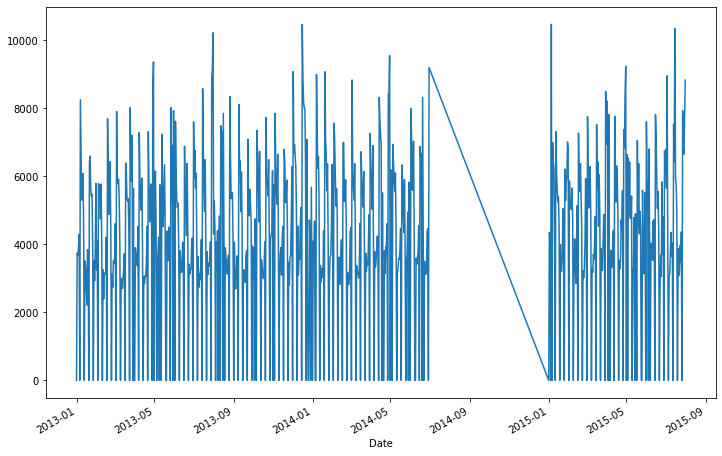

In [130]:
#trying to do the linear interpolation of the missing values.
df_store13.interpolate(method='time', inplace=False)['Sales'].plot()

### We see that linear interpolation doesn't work bad that good so we will use a VARMAX model to predict the missing data from the available data.

In [131]:
#we don't have any missing values in the available data
df_store13.isna().sum()

Store                     0
DayOfWeek                 0
Sales                     0
Customers                 0
Open                      0
Promo                     0
SchoolHoliday             0
StateHoliday_Christmas    0
StateHoliday_Easter       0
StateHoliday_None         0
StateHoliday_Public       0
Holiday_Sunday            0
dtype: int64

### Outliers Treatment
- Values beyond 99.9% percentiles shall be removed


(758, 12)

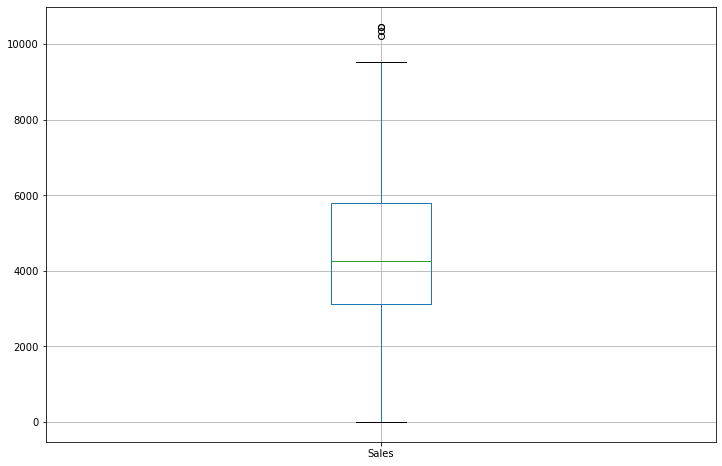

In [132]:
df_store13[['Sales']].boxplot()

df_store13.shape

In [133]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store13, outlier_rows = make_outliers_nan(df_store13)

(758, 12)


In [134]:
#We assigned NaN to all the outlier, 8 values of Sales
df_store13.loc[outlier_rows][['Sales', 'Customers']]

Sales  Customers
Date                        
2013-04-30    NaN        664
2013-07-31    NaN        641
2013-12-16    NaN        649
2014-04-30    NaN        645
2014-06-30    NaN        585
2015-01-05    NaN        672
2015-04-30    NaN        639
2015-07-15    NaN        415

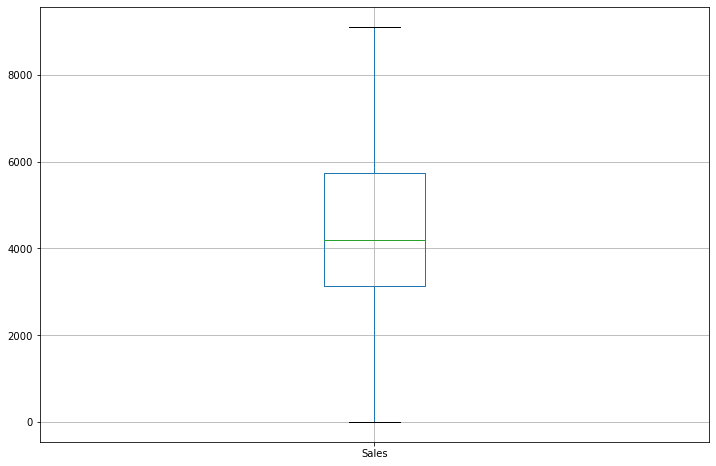

In [135]:
df_store13[['Sales']].boxplot()

In [136]:
#adding missing dates to the store dataframe. All the values in all columns are assigned Nan
for date in pd.to_datetime([date for date in pd.date_range(start ='2013-01-01', 
         end ='31-07-2015') if date not in df_store13.index],format="%Y-%m-%d"):
    df_store13.loc[date] = np.nan
#The data now has all the dates
print(df_store13.shape)

(942, 12)


In [137]:
#Getting the missing dates
missing_dates = df_store13[df_store13['StateHoliday_Easter'].isna()].index

In [138]:
#Now we want to add values to all the columns other than Sales and Customers. Here, I am using data from another
#store 440 which has the same store type, assortment, promo etc values as Store 13. 
#Also, columns like SchoolHolidays, DayOfWeek, Sundays etc are gonna remain the same
df_store440 = data_df[data_df['Store']==440]
df_store440 = df_store440.sort_index()

df_store440.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01    440          2      0          0     0      0              1   
2013-01-02    440          3   4503        596     1      0              1   
2013-01-03    440          4   4187        550     1      0              1   
2013-01-04    440          5   4445        553     1      0              1   
2013-01-05    440          6   3172        362     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

In [139]:
#Assigning data from store 440 to Store 13
df_store13.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), :] = df_store440.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), :].values
df_store13 = df_store13.sort_index()
df_store13.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31'))].head()

Store  DayOfWeek   Sales  Customers  Open  Promo  SchoolHoliday  \
2014-07-01  440.0        2.0  6995.0      733.0   1.0    1.0            0.0   
2014-07-02  440.0        3.0  5813.0      650.0   1.0    1.0            0.0   
2014-07-03  440.0        4.0  5959.0      666.0   1.0    1.0            0.0   
2014-07-04  440.0        5.0  5791.0      671.0   1.0    1.0            0.0   
2014-07-05  440.0        6.0  3662.0      389.0   1.0    0.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
2014-07-01                     0.0                  0.0                1.0   
2014-07-02                     0.0                  0.0                1.0   
2014-07-03                     0.0                  0.0                1.0   
2014-07-04                     0.0                  0.0                1.0   
2014-07-05                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  
2014-07-01                  0.0             0.0  
2014-07-02                  0.0             0.0  
2014-07-03                  0.0             0.0  
2014-07-04                  0.0             0.0  
2014-07-05                  0.0             0.0

In [140]:
#Assigning NaN to Sales and Customers because those values are from Store 440 
#Assigning Store id = 13 to all 440 store ids
df_store13.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), ['Sales', 'Customers']] = np.nan
df_store13.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), ['Store']] = 13
df_store13.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31'))].head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
2014-07-01   13.0        2.0    NaN        NaN   1.0    1.0            0.0   
2014-07-02   13.0        3.0    NaN        NaN   1.0    1.0            0.0   
2014-07-03   13.0        4.0    NaN        NaN   1.0    1.0            0.0   
2014-07-04   13.0        5.0    NaN        NaN   1.0    1.0            0.0   
2014-07-05   13.0        6.0    NaN        NaN   1.0    0.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
2014-07-01                     0.0                  0.0                1.0   
2014-07-02                     0.0                  0.0                1.0   
2014-07-03                     0.0                  0.0                1.0   
2014-07-04                     0.0                  0.0                1.0   
2014-07-05                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  
2014-07-01                  0.0             0.0  
2014-07-02                  0.0             0.0  
2014-07-03                  0.0             0.0  
2014-07-04                  0.0             0.0  
2014-07-05                  0.0             0.0

In [141]:
#Preparing interpolation data. We are using data from dates '2013-01-01' to '2014-06-29' to predict missing data
interp_data = df_store13.loc[pd.to_datetime([date for date in pd.date_range(start ='2013-01-01', 
         end ='2014-06-29')])]
print(interp_data.shape)

(545, 12)


In [142]:
#We have few Nan values generated because of outliers removal. we want to interpolate using simple linear
#interpolation
interp_data[interp_data['Sales'].isna()]

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
2013-04-30   13.0        2.0    NaN      664.0   1.0    1.0            0.0   
2013-07-31   13.0        3.0    NaN      641.0   1.0    1.0            1.0   
2013-12-16   13.0        1.0    NaN      649.0   1.0    1.0            0.0   
2014-04-30   13.0        3.0    NaN      645.0   1.0    1.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
2013-04-30                     0.0                  0.0                1.0   
2013-07-31                     0.0                  0.0                1.0   
2013-12-16                     0.0                  0.0                1.0   
2014-04-30                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  
2013-04-30                  0.0             0.0  
2013-07-31                  0.0             0.0  
2013-12-16                  0.0             0.0  
2014-04-30                  0.0             0.0

In [143]:
#using linear interpolation to finalize train data
interp_data.interpolate(method='linear', inplace=True)

In [144]:
#splitting data for training model to predict future values. I have taken apart 10 values to test the model
interp_train_data, interp_test_data = data_split(10, interp_data)

(535, 12)
(10, 12)


In [145]:
#Standardizing data before modelling
intp_train = interp_train_data.copy()
intp_test = interp_test_data.copy()
intp_train[['Sales', 'Customers']], intp_test[['Sales', 'Customers']], scaler_intp = data_standardization(interp_train_data[['Sales', 'Customers']], interp_test_data[['Sales', 'Customers']])

In [146]:
# ADF Test on each column
for name, column in intp_train[['Sales', 'Customers']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2082
 No. Lags Chosen       = 16
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0702
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




### Both Sales and Customers are stationary so we can use VARMAX 

In [147]:
#Model building for predicting the missing 184 values
exog_intp = intp_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_intp = VARMAX(intp_train[['Sales', 'Customers']], order=(7,7),trend='n', exog=exog_intp)
results_intp = mod_intp.fit(maxiter=1000, disp=False)
#predicting the 10 test values 
exog_intp = intp_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_intp = results_intp.forecast(10, exog=exog_intp)
predictions_intp.index = intp_test.index
predictions_intp.head()

Sales  Customers
2014-06-20  1.302943   1.210128
2014-06-21  0.178810   0.306228
2014-06-22 -1.677923  -1.853153
2014-06-23 -0.163318   0.043675
2014-06-24 -0.348052  -0.107146

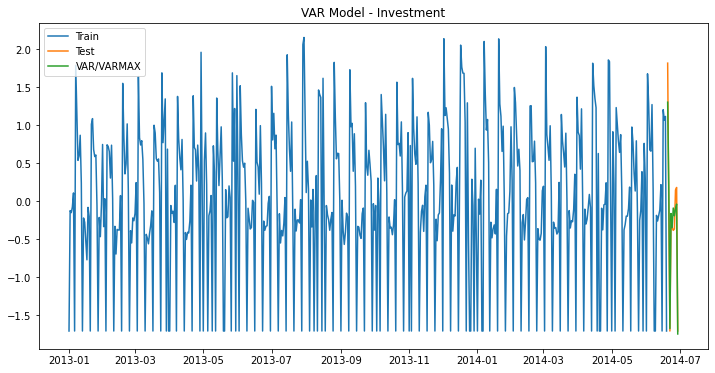

In [148]:
#plotting Train, Test and VARMAX
show_testVsPred_plot(intp_train['Sales'], intp_test['Sales'], predictions_intp['Sales'])

### we can see from the plot that our model predicted the test values acceptably alright. So, we now will use the complete train data and predict missing 184 Sales and Customers values

In [149]:
#Standardizing final training data for interpolation
intp_final_train, intp_final_test, scaler_intp = data_standardization(interp_data[['Sales', 'Customers']], interp_data[['Sales', 'Customers']])

In [150]:
intp_final_train.shape

(545, 2)

In [151]:
#final model with all full training data to interpolate missing data
exog_intp_final = interp_data[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_intp_final = VARMAX(intp_final_train, order=(7,7),trend='n', exog=exog_intp_final)
results_intp_final = mod_intp_final.fit(maxiter=1000, disp=False)
exog_intp_final = df_store13.loc[missing_dates][['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_intp_final = results_intp_final.forecast(184, exog=exog_intp_final)
predictions_intp_final.index = missing_dates
predictions_intp_final.columns=['Sales', 'Customers']
predictions_intp_final.head()

Sales  Customers
Date                           
2014-07-01  1.486540   1.291568
2014-07-02  1.141589   0.923366
2014-07-03  0.769229   0.700869
2014-07-04  0.532309   0.516741
2014-07-05 -0.166483   0.089540

In [152]:
interp_data[['Sales_std', 'Customers_std']] = intp_final_train 

In [153]:
interp_data[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
2013-01-01  -1.706710      -1.859210
2013-01-02  -0.120078       0.003169
2013-01-03  -0.146826      -0.143706
2013-01-04  -0.072950       0.138295
2013-01-05   0.112588       0.161795

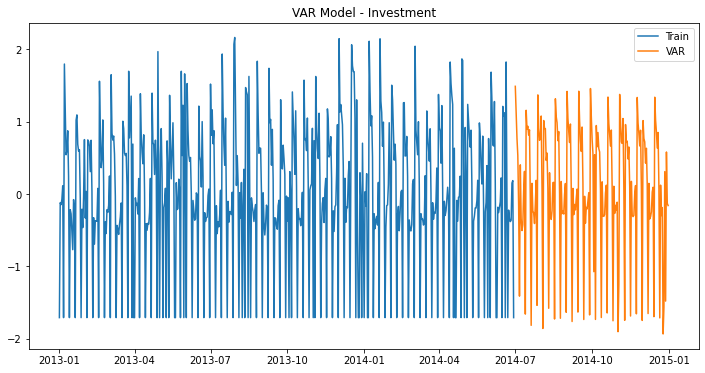

In [154]:
plt.figure(figsize=(12,6))
plt.plot(interp_data[['Sales_std']], label='Train')
plt.plot(predictions_intp_final['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Investment')
plt.show()

In [155]:
#above graph looks fine. we will now transform the values to original scale
#preparing final interpolated dataset
interpolated_data_original_scale = scaler_intp.inverse_transform(predictions_intp_final)
df_store13.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), ['Sales', 'Customers']] = interpolated_data_original_scale
df_store13.interpolate(method='linear', inplace=True)
df_store13.loc[df_store13[(df_store13['Open']==0) & (df_store13['Sales']!=0)].index, ['Sales', 'Customers']] = 0

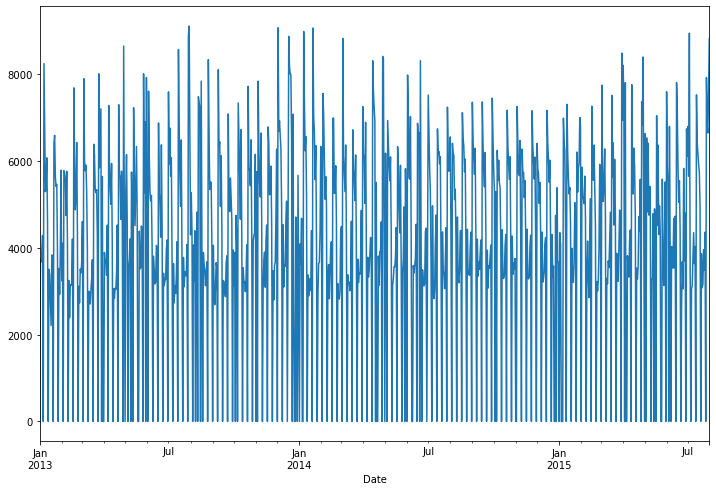

In [156]:
df_store13['Sales'].plot()

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

### Splitting the Data into Training and Testing Sets

In [157]:
df_store13 = df_store13.sort_index()
#splitting data for training model to predict future values
nobs = 42
store13_train, store13_test = data_split(nobs, df_store13)

(900, 12)
(42, 12)


In [158]:
#Standardizing final training data for interpolation
store13_train[['Sales_std', 'Customers_std']], store13_test[['Sales_std', 'Customers_std']], scaler_store13 = data_standardization(store13_train[['Sales', 'Customers']], store13_test[['Sales', 'Customers']])

store13_train.head()

Store  DayOfWeek   Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                          
2013-01-01   13.0        2.0     0.0        0.0   0.0    0.0            1.0   
2013-01-02   13.0        3.0  3737.0      317.0   1.0    0.0            1.0   
2013-01-03   13.0        4.0  3674.0      292.0   1.0    0.0            1.0   
2013-01-04   13.0        5.0  3848.0      340.0   1.0    0.0            1.0   
2013-01-05   13.0        6.0  4285.0      344.0   1.0    0.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                     0.0                  0.0                0.0   
2013-01-02                     0.0                  0.0                1.0   
2013-01-03                     0.0                  0.0                1.0   
2013-01-04                     0.0                  0.0                1.0   
2013-01-05                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  Sales_std  Customers_std  
Date                                                                       
2013-01-01                  1.0             0.0  -1.753808      -1.901673  
2013-01-02                  0.0             0.0  -0.142002       0.004038  
2013-01-03                  0.0             0.0  -0.169174      -0.146255  
2013-01-04                  0.0             0.0  -0.094126       0.142307  
2013-01-05                  0.0             0.0   0.094356       0.166354

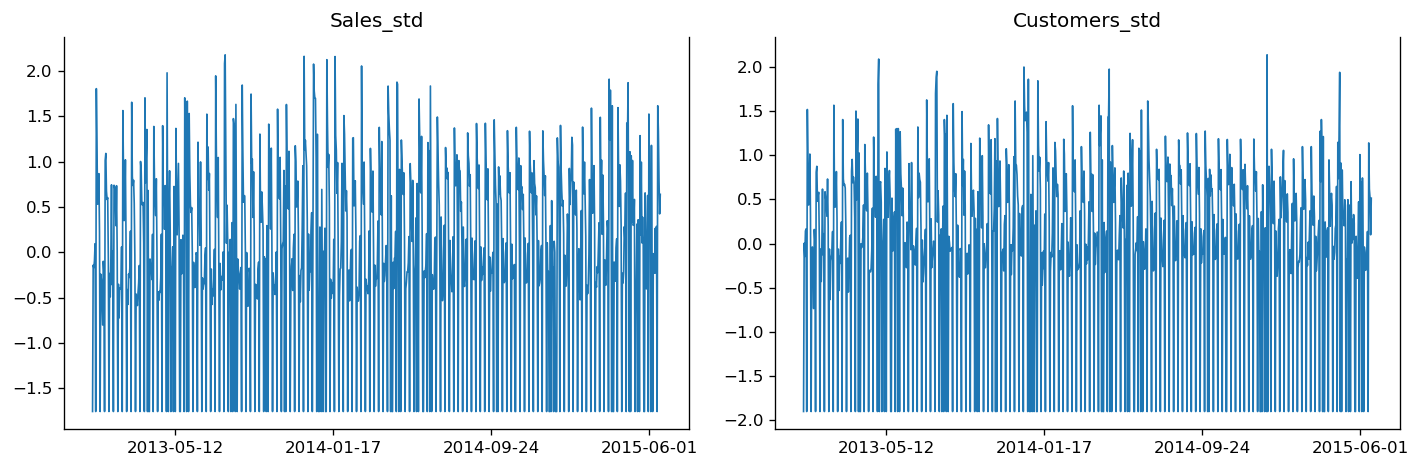

In [159]:
# Plot
ls=['Sales_std','Customers_std']
df=store13_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,4))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # Decorations
        ax.set_title(df.columns[i])
        ax.spines["top"].set_alpha(0)
        
plt.tight_layout();

In [160]:
# ADF Test on each column
for name, column in store13_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1166
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9686
 No. Lags Chosen       = 20
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




### Since both Sales ans Customers are stationary, we can build VARMAX model

In [161]:
exog = store13_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,7]:
    for j in [1,7]:
        mod = VARMAX(store13_train[['Sales_std', 'Customers_std']], order=(i,j),trend='n', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model 

Lag Order = 1 1
AIC :  452.51176278962595
BIC :  572.5716318727337
HQIC:  498.3754988527003 

Lag Order = 1 7
AIC :  439.2108165987288
BIC :  674.5281600016201
HQIC:  529.1037392823546 

Lag Order = 7 1
AIC :  296.19674843247986
BIC :  531.5140918353711
HQIC:  386.0896711161056 

Lag Order = 7 7
AIC :  241.2011074827135
BIC :  591.7759252053883
HQIC:  375.1232167868906 



In [162]:
#Building model after considering hyperparameter values we got from previous step
exog = store13_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_store13 = VARMAX(store13_train[['Sales_std', 'Customers_std']], order=(7,7),trend='c', exog=exog)
res_store13 = mod_store13.fit(maxiter=1000, disp=False)

In [163]:
exog = store13_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions = res_store13.forecast(steps= 42, exog=exog)
predictions.index = store13_test.index
predictions.head()

Sales_std  Customers_std
Date                                
2015-06-20  -0.016041       0.122600
2015-06-21  -1.814508      -2.008454
2015-06-22   0.031177       0.130669
2015-06-23  -0.437251      -0.303344
2015-06-24  -0.287209      -0.194510

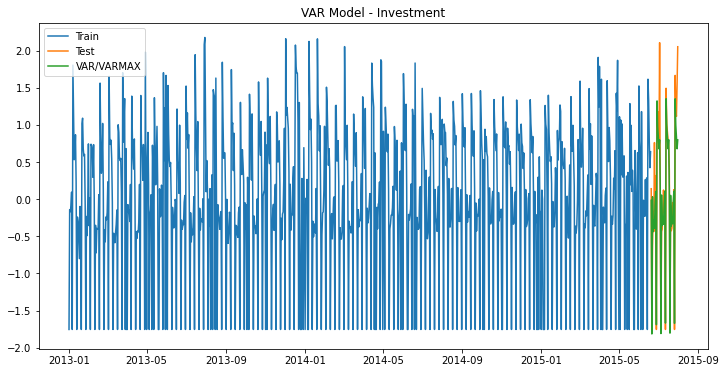

In [164]:
show_testVsPred_plot(store13_train['Sales_std'], store13_test['Sales_std'], predictions['Sales_std'])

In [165]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store13_test['Sales_std'], predictions['Sales_std']))
print(rmse)

0.4132685763480037


In [166]:
#converting standardized values back to orignal form
actual_store13 = pd.DataFrame(scaler_store13.inverse_transform(store13_test[['Sales_std', 'Customers_std']]))[0]
predicted_store13 = pd.DataFrame(scaler_store13.inverse_transform(predictions[['Sales_std', 'Customers_std']]))[0]

In [167]:
#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store13, predicted_store13], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual    Predicted
0  4391.0  4029.043139
1     0.0  -140.734378
2  2603.0  4138.517488
3  3681.0  3052.460703
4  3056.0  3400.335667
5  5830.0  3154.573572
6  3702.0  3900.498256
7  4801.0  4304.370486
8     0.0   148.771360
9  6741.0  7130.142960

In [168]:
sqrt(mean_squared_error(actual_store13,predicted_store13))

958.1702733243851

In [169]:
#MAPE value without 0 sales values
mape_store13 = mean_absolute_percentage_error(actual_store13, predicted_store13)
print(mape_store13)

13.201331831548563


In [170]:
final_results = final_results.append({'Store':'Store13', 'MAPE':mape_store13},ignore_index=True)
final_results

Store       MAPE
0   Store1   9.482873
1   Store3   8.148553
2   Store8  14.954222
3   Store9   2.385221
4  Store13  13.201332

## Result Analysis:-
    - We can see that from the predicted vs Actual values that the predicted values came out to be very close to each other. The rows where actual Sales were 0, our model has predicted a value close to 0
    - We can consider low values of Sales as an indictor that there will be close to none, i.e., 0 sales on that particular day
    - For this store, I have predicted Sales for the next 42 days which is 6 weeks prediction as required.

# Store 25 Analysis and Prediction

In [171]:
#Get store specific data
df_store25 = data_df[data_df['Store']==25]
df_store25 = df_store25.sort_index()

df_store25.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01     25          2      0          0     0      0              1   
2013-01-02     25          3  11944       1698     1      0              1   
2013-01-03     25          4  10409       1587     1      0              1   
2013-01-04     25          5   9729       1520     1      0              1   
2013-01-05     25          6   8987       1381     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

In [172]:
df_store25.shape

(942, 12)

In [173]:
df_store25.isna().sum()

Store                     0
DayOfWeek                 0
Sales                     0
Customers                 0
Open                      0
Promo                     0
SchoolHoliday             0
StateHoliday_Christmas    0
StateHoliday_Easter       0
StateHoliday_None         0
StateHoliday_Public       0
Holiday_Sunday            0
dtype: int64

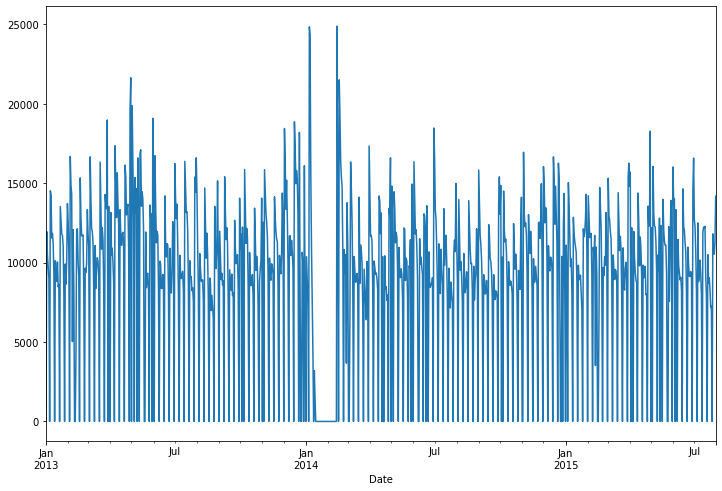

In [174]:
df_store25['Sales'].plot()

#### from the above plot, we can see that some values are missing and all the Sales and Customers values are 0. Data between dates 15-01-2014 and 13-02-2014 is missing. Let's try to interpolate them using previous values. Similar to what we did it for Store 13

In [175]:
df_store25.loc[pd.to_datetime(pd.date_range(start ='2014-01-14', end ='2014-02-14'),format="%Y-%m-%d"), ['Sales', 'Customers']]

Sales  Customers
2014-01-14   1410        237
2014-01-15      0          0
2014-01-16      0          0
2014-01-17      0          0
2014-01-18      0          0
2014-01-19      0          0
2014-01-20      0          0
2014-01-21      0          0
2014-01-22      0          0
2014-01-23      0          0
2014-01-24      0          0
2014-01-25      0          0
2014-01-26      0          0
2014-01-27      0          0
2014-01-28      0          0
2014-01-29      0          0
2014-01-30      0          0
2014-01-31      0          0
2014-02-01      0          0
2014-02-02      0          0
2014-02-03      0          0
2014-02-04      0          0
2014-02-05      0          0
2014-02-06      0          0
2014-02-07      0          0
2014-02-08      0          0
2014-02-09      0          0
2014-02-10      0          0
2014-02-11      0          0
2014-02-12      0          0
2014-02-13      0          0
2014-02-14  24882       2835

In [176]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store25, outlier_rows = make_outliers_nan(df_store25)

#We assigned NaN to all the outlier,  values of Sales
df_store25.loc[outlier_rows][['Sales', 'Customers']]

(942, 12)


Sales  Customers
Date                        
2013-03-28    NaN       2376
2013-04-29    NaN       2458
2013-04-30    NaN       2485
2013-05-02    NaN       2576
2013-05-31    NaN       2299
2014-01-06    NaN       2111
2014-01-07    NaN       2109
2014-02-14    NaN       2835
2014-02-17    NaN       2368
2014-02-18    NaN       2258

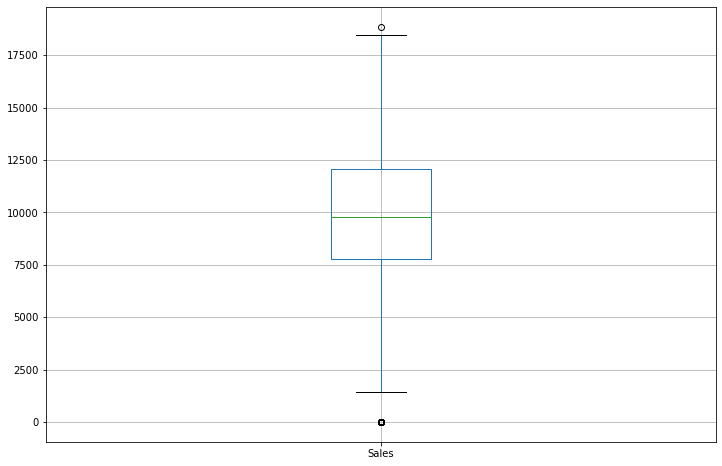

In [177]:
df_store25[['Sales']].boxplot()

In [178]:
#Getting the missing dates
missing_dates = pd.to_datetime(pd.date_range(start ='2014-01-15', end ='2014-02-13'),format="%Y-%m-%d")

#Preparing interpolation data. We are using data from dates '2013-01-01' to '2014-01-14' to predict missing data
interp_data = df_store25.loc[pd.to_datetime([date for date in pd.date_range(start ='2013-01-01', 
         end ='2014-01-14')])]
print(interp_data.shape)
print(len(missing_dates))

(379, 12)
30


In [179]:
#We have few Nan values generated because of outliers removal. we want to interpolate using simple linear
#interpolation
print(interp_data[interp_data['Sales'].isna()])

#using linear interpolation to finalize train data
interp_data.interpolate(method='linear', inplace=True)

            Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
2013-03-28     25          4    NaN       2376     1      1              1   
2013-04-29     25          1    NaN       2458     1      1              0   
2013-04-30     25          2    NaN       2485     1      1              0   
2013-05-02     25          4    NaN       2576     1      1              0   
2013-05-31     25          5    NaN       2299     1      1              0   
2014-01-06     25          1    NaN       2111     1      1              1   
2014-01-07     25          2    NaN       2109     1      1              1   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
2013-03-28                       0                    0                  1   
2013-04-29                       0                    0                  1   
2013-04-30                       0                    0                  1   
2013-05-02                       0                    0        

In [180]:
interp_data.shape

(379, 12)

In [181]:
#splitting data for training model to predict future values. I have taken apart 10 values to test the model
interp_train_data, interp_test_data = data_split(10, interp_data)

intp_train_s25 = interp_train_data.copy()
intp_test_s25 = interp_test_data.copy()

#Standardizing data before modelling
intp_train_s25[['Sales', 'Customers']], intp_test_s25[['Sales', 'Customers']], scaler_intp = data_standardization(interp_train_data[['Sales', 'Customers']], interp_test_data[['Sales', 'Customers']])

# ADF Test on each column
for name, column in intp_train_s25[['Sales', 'Customers']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

(369, 12)
(10, 12)
    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1673
 No. Lags Chosen       = 16
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6681
 No. Lags Chosen       = 13
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0797. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [182]:
### Both Sales and Customers are stationary so we can use VARMAX 

exog_intp = intp_train_s25[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_intp = VARMAX(intp_train_s25[['Sales', 'Customers']], order=(7,7),trend='n', exog=exog_intp)
results_intp = mod_intp.fit(maxiter=1000, disp=False)

exog_intp = intp_test_s25[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_intp = results_intp.forecast(10, exog=exog_intp)
predictions_intp.index = intp_test_s25.index
predictions_intp.head()

Sales  Customers
2014-01-05 -1.762178  -1.885837
2014-01-06  0.598593   0.624341
2014-01-07  0.248416   0.257213
2014-01-08  0.438356   0.395307
2014-01-09  0.621242   0.673879

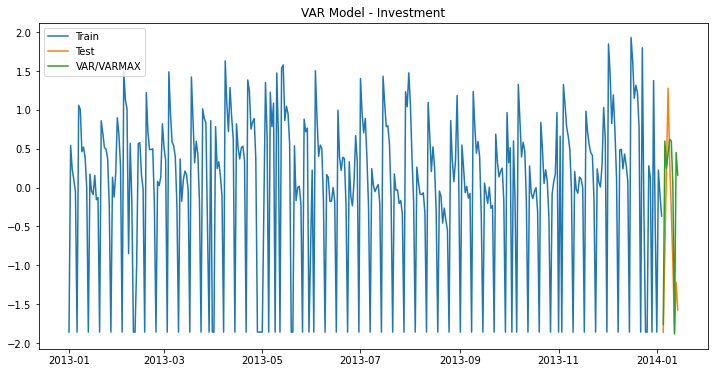

In [183]:
show_testVsPred_plot(intp_train_s25['Sales'], intp_test_s25['Sales'], predictions_intp['Sales'])

### we can see from the plot that our model predicted the test values acceptably alright. So, we now will use the complete train data and predict missing 184 Sales and Customers values

In [184]:
#Standardizing final training data for interpolation
intp_final_train, intp_final_test, scaler_intp = data_standardization(interp_data[['Sales', 'Customers']], interp_data[['Sales', 'Customers']])

intp_final_train.shape

(379, 2)

In [185]:
exog_intp_final = interp_data[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_intp_final = VARMAX(intp_final_train, order=(7,7),trend='n', exog=exog_intp_final)
results_intp_final = mod_intp_final.fit(maxiter=1000, disp=False)
exog_intp_final = df_store25.loc[missing_dates][['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_intp_final = results_intp_final.forecast(len(missing_dates), exog=exog_intp_final)
predictions_intp_final.index = missing_dates
predictions_intp_final.columns=['Sales', 'Customers']
predictions_intp_final.head()

Sales  Customers
2014-01-15 -0.645660  -0.776643
2014-01-16  0.063637  -0.035322
2014-01-17 -0.340124  -0.336081
2014-01-18 -0.500044  -0.587347
2014-01-19 -2.005736  -2.152677

In [186]:
interp_data[['Sales_std', 'Customers_std']] = intp_final_train 

interp_data[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
2013-01-01  -1.832082      -1.946446
2013-01-02   0.556509       0.514385
2013-01-03   0.249536       0.353518
2013-01-04   0.113548       0.256418
2013-01-05  -0.034839       0.054972

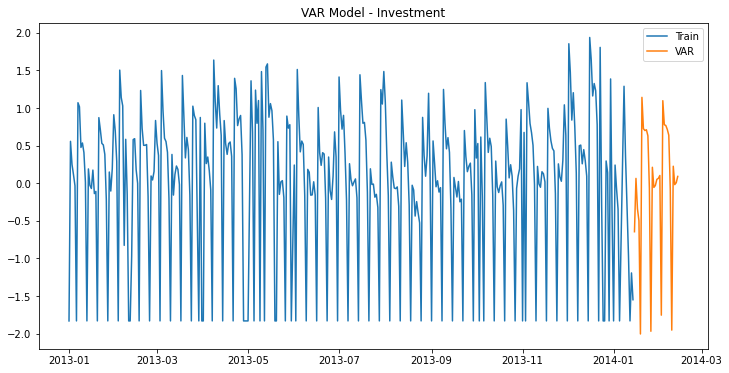

In [187]:
plt.figure(figsize=(12,6))
plt.plot(interp_data[['Sales_std']], label='Train')
plt.plot(predictions_intp_final['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Investment')
plt.show()

In [188]:
#above graph looks fine. we will now transform the values to original scale
#preparing final interpolated dataset
interpolated_data_original_scale = scaler_intp.inverse_transform(predictions_intp_final)
df_store25.loc[pd.to_datetime(pd.date_range(start ='2014-01-15', end ='2014-02-13')), ['Sales', 'Customers']] = interpolated_data_original_scale
df_store25.interpolate(method='linear', inplace=True)

In [189]:
df_store25.loc[df_store25[(df_store25['DayOfWeek']==7) & (df_store25['Sales']!=0)].index, ['Sales', 'Customers']]=0

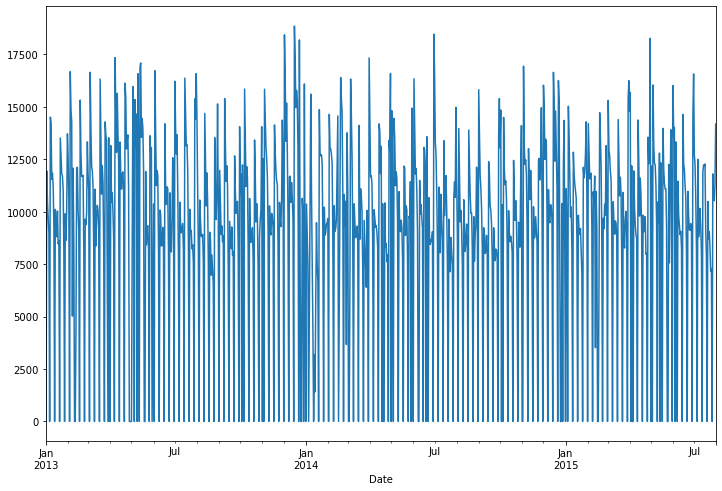

In [190]:
df_store25['Sales'].plot()

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

### Splitting the Data into Training and Testing Sets

In [191]:
#Perform a train-test split

nobs = 42
store25_train, store25_test = df_store25[0:-nobs], df_store25[-nobs:]

# Check size
print(store25_train.shape) 
print(store25_test.shape)  

(900, 12)
(42, 12)


In [192]:
# Apply standardization scaling
scaler_store25 = StandardScaler()

# Apply scaler() to all the columns
scaler_store25.fit(store25_train[['Sales', 'Customers']])
store25_train[['Sales', 'Customers']] = scaler_store25.transform(store25_train[['Sales', 'Customers']])

# Apply the scaler to the test data set too
store25_test[['Sales', 'Customers']] = scaler_store25.transform(store25_test[['Sales', 'Customers']])

store25_train.head()

Store  DayOfWeek     Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                            
2013-01-01     25          2 -1.869350  -1.962358     0      0              1   
2013-01-02     25          3  0.603619   0.605347     1      0              1   
2013-01-03     25          4  0.285802   0.437493     1      0              1   
2013-01-04     25          5  0.145010   0.336176     1      0              1   
2013-01-05     25          6 -0.008619   0.125981     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

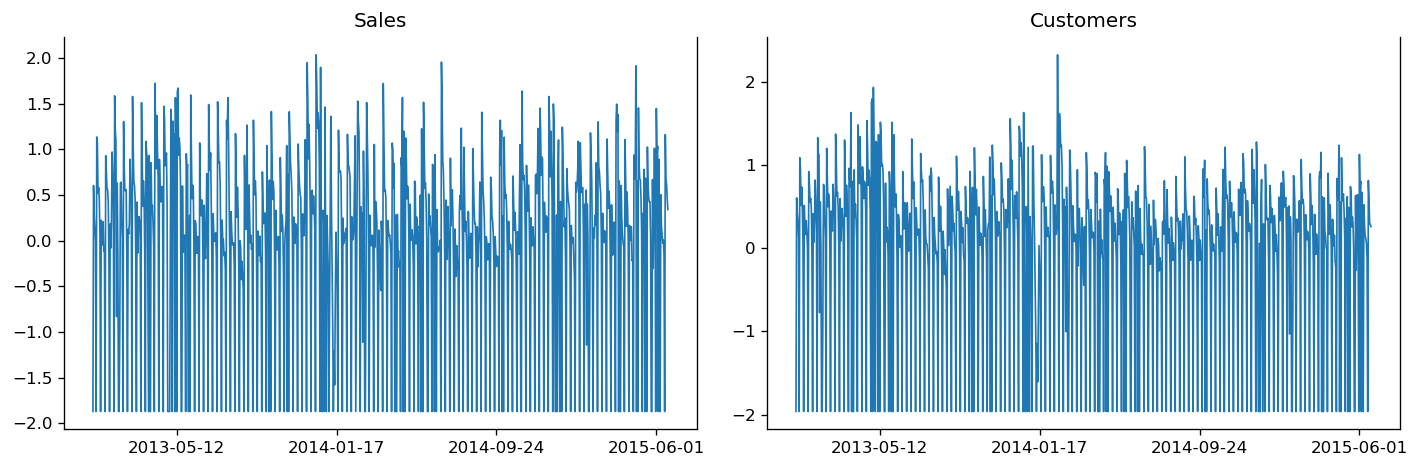

In [193]:
# Plot
ls=['Sales','Customers']
df=store25_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,4))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # Decorations
        ax.set_title(df.columns[i])
        ax.spines["top"].set_alpha(0)
        
plt.tight_layout();

In [194]:
# ADF Test on each column
for name, column in store25_train[['Sales', 'Customers']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8186
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9164
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [195]:
exog = store25_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,7]:
    for j in [1,7]:
        mod = VARMAX(store25_train[['Sales', 'Customers']], order=(i,j),trend='n', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model 

Lag Order = 1 1
AIC :  833.3220349776298
BIC :  953.3819040607375
HQIC:  879.1857710407041 

Lag Order = 1 7
AIC :  700.4575900047846
BIC :  935.7749334076759
HQIC:  790.3505126884104 

Lag Order = 7 1
AIC :  739.9448668333773
BIC :  975.2622102362686
HQIC:  829.8377895170031 

Lag Order = 7 7
AIC :  670.9112908554555
BIC :  1021.4861085781301
HQIC:  804.8334001596327 



In [196]:
exog = store25_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod = VARMAX(store25_train[['Sales', 'Customers']], order=(7,7),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)

In [197]:
exog = store25_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions = res.forecast(steps= 42, exog=exog)
predictions.index = store25_test.index
predictions.head()

Sales  Customers
Date                           
2015-06-20 -0.128276  -0.113156
2015-06-21 -2.002492  -2.093196
2015-06-22  0.187353   0.311744
2015-06-23 -0.047958   0.091013
2015-06-24 -0.021052   0.067895

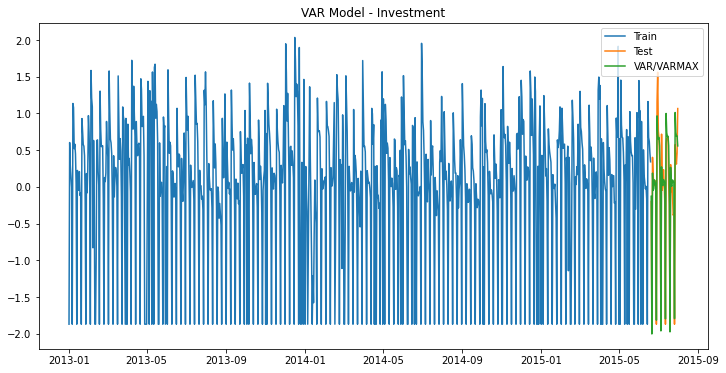

In [198]:
show_testVsPred_plot(store25_train['Sales'], store25_test['Sales'], predictions['Sales'])

In [199]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store25_test['Sales'], predictions['Sales']))
print(rmse)

0.2664256121530513


In [200]:
#converting standardized values back to orignal form
actual_store25 = pd.DataFrame(scaler_store25.inverse_transform(store25_test[['Sales', 'Customers']]))[0]
predicted_store25 = pd.DataFrame(scaler_store25.inverse_transform(predictions[['Sales', 'Customers']]))[0]

#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store25, predicted_store25], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual     Predicted
0   8067.0   8409.077812
1      0.0   -643.050105
2  10972.0   9933.509407
3   9788.0   8796.996155
4   9138.0   8926.948458
5   9116.0   9490.304345
6   9430.0   9332.049063
7   9082.0   9150.441543
8      0.0    267.409350
9  14621.0  13697.015571

In [201]:
sqrt(mean_squared_error(actual_store25,predicted_store25))

1286.7879803345018

In [202]:
#MAPE value without 0 sales values
mape_store25 = mean_absolute_percentage_error(actual_store25, predicted_store25)
print(mape_store25)

9.623493208687126


In [203]:
final_results = final_results.append({'Store':'Store25', 'MAPE':mape_store25},ignore_index=True)
final_results

Store       MAPE
0   Store1   9.482873
1   Store3   8.148553
2   Store8  14.954222
3   Store9   2.385221
4  Store13  13.201332
5  Store25   9.623493

## Result Analysis:-
    - We can see that from the predicted vs Actual values that the predicted values came out to be very close to each other. The rows where actual Sales were 0, our model has predicted a value close to 0
    - We can consider low values of Sales as an indictor that there will be close to none, i.e., 0 sales on that particular day
    - For this store, I have predicted Sales for the next 42 days which is 6 weeks prediction as required.

# Store 29 Analysis and Prediction

In [204]:
#Get store specific data
df_store29 = data_df[data_df['Store']==29]
df_store29 = df_store29.sort_index()

df_store29.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01     29          2      0          0     0      0              1   
2013-01-02     29          3   5269        550     1      0              1   
2013-01-03     29          4   4554        456     1      0              1   
2013-01-04     29          5   5411        505     1      0              1   
2013-01-05     29          6   5564        537     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

### Outliers Treatment
- Values beyond 99.9% percentiles shall be removed

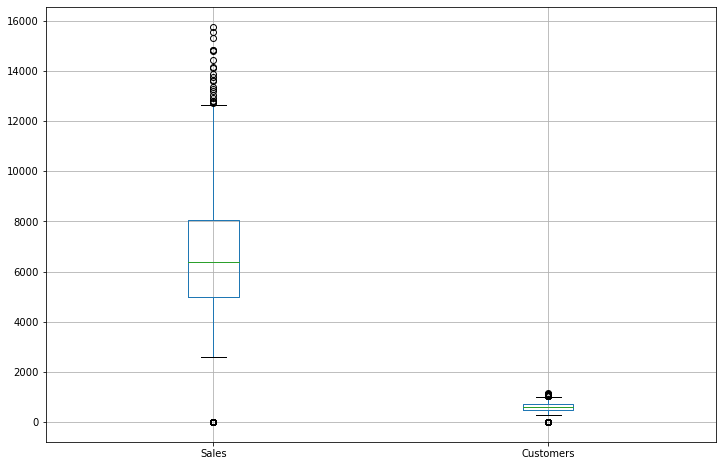

In [205]:
df_store29[['Sales', 'Customers']].boxplot()

In [206]:
df_store29.shape

(942, 12)

In [207]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store29, outlier_rows = make_outliers_nan(df_store29)

(942, 12)


In [208]:
#We assigned NaN to all the outlier,  values of Sales
df_store29.loc[outlier_rows][['Sales', 'Customers']]

Sales  Customers
Date                        
2013-12-16    NaN       1091
2014-02-03    NaN       1054
2014-06-30    NaN       1067
2014-11-03    NaN       1084
2014-12-01    NaN       1038
2014-12-15    NaN       1092
2015-03-30    NaN        996
2015-06-01    NaN       1111
2015-06-15    NaN       1059
2015-06-29    NaN       1027

In [209]:
df_store29.interpolate(method='linear', inplace=True)

### I am sampling daily data to weekly data to make the trend clearer

In [210]:
store29_1w = df_store29.resample('1w').mean()   

store29_1w.shape

(135, 12)

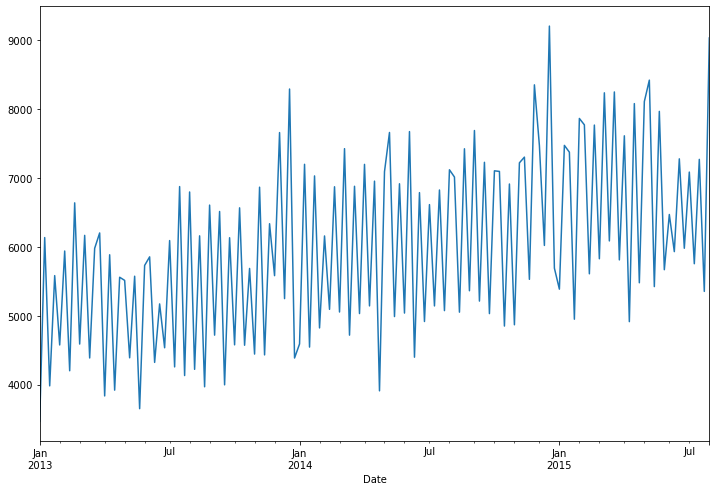

In [211]:
store29_1w['Sales'].plot()

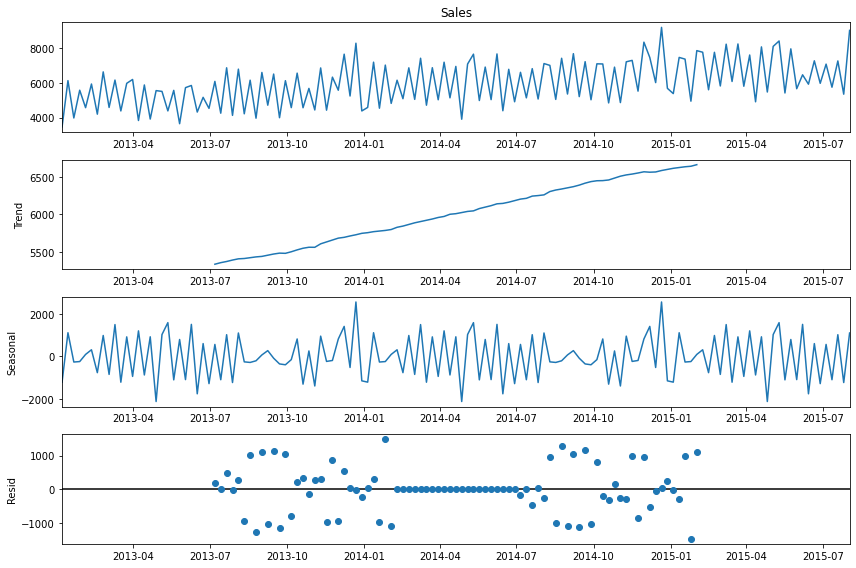

In [212]:
series_decomposition(store29_1w['Sales'])

### We see a clear upward trend in this dataset. We will prepare train and test data to train the model

#### Splitting the Data into Training and Testing Sets and then data standardization

In [213]:
#Perform a train-test split
nobs = 6
store29_train, store29_test = data_split(nobs, store29_1w)

(129, 12)
(6, 12)


In [214]:
#Standardizing data before modelling
store29_train[['Sales_std', 'Customers_std']], store29_test[['Sales_std', 'Customers_std']], scaler_store29 = data_standardization(store29_train[['Sales', 'Customers']], store29_test[['Sales', 'Customers']])
store29_train[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
Date                                
2013-01-06  -1.926878      -2.163015
2013-01-13   0.133124       0.005548
2013-01-20  -1.528312      -1.666227
2013-01-27  -0.293194      -0.513656
2013-02-03  -1.070083      -1.259621

In [215]:
# ADF Test on each column
for name, column in store29_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9275
 No. Lags Chosen       = 10
 Critical value 1%     = -3.487
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.7788. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2538
 No. Lags Chosen       = 8
 Critical value 1%     = -3.486
 Critical value 5%     = -2.886
 Critical value 10%    = -2.58
 => P-Value = 0.6501. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




### We can see that Adfuller test showed that both Series and Customers time series are Non-Stationary. 
### We will now perform Johansen Cointegration Test to see if both series are cointegrated or not.

In [216]:
joh_model1 = coint_johansen(store29_train[['Sales_std', 'Customers_std']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0     38.176808   58.821801
1     20.644993   20.644993 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



Trace and maximum eigenvalue Statistics are bigger than its Critical 95% level so we reject the null hypothesis and accept that there exists cointegration. Let's confirm it using Granger Causality Tests

In [217]:
grangers_causation_matrix(store29_train, variables = ['Sales_std', 'Customers_std'])   

Sales_std_x  Customers_std_x
Sales_std_y           1.0000           0.1812
Customers_std_y       0.0477           1.0000

#### We have p values less than 0.05 so we can reject the Grangers Causality test null hypothesis that x(t) doesn't Granger-cause y(t) means x(t) cause y(t). So, we are now sure that both Sales and Customers time series are Cointegrated

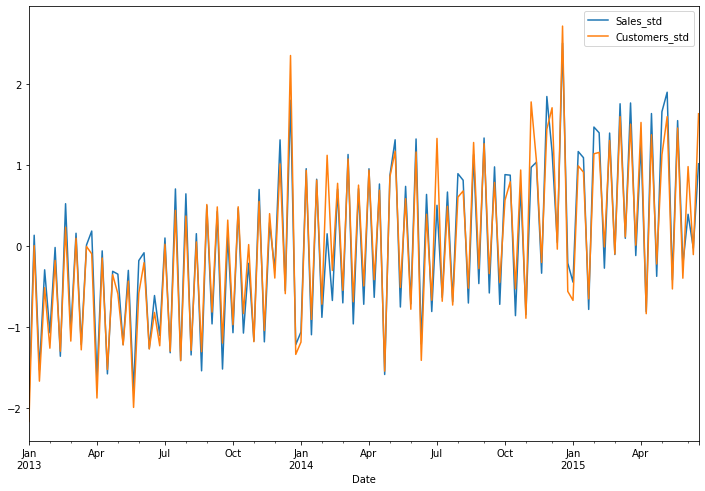

In [218]:
store29_train[['Sales_std', 'Customers_std']].plot()

#### Finally,  the plot shows that Sales and Customers time series are Cointegrated too. So, now we will go ahead and build VAR/VARMAX model

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

In [219]:
#For VAR model, we will take 0 value of j to build VAR model from VARMAX function itself
exog = store29_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,5,7]:
    for j in [0, 1,7]:
        mod = VARMAX(store29_train[['Sales_std', 'Customers_std']], order=(i,j),trend='n', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model

Lag Order = 1 0
AIC :  231.26952114526915
BIC :  291.3255816368643
HQIC:  255.67151430942576 

Lag Order = 1 1
AIC :  147.51421362709428
BIC :  219.0095237361361
HQIC:  176.5642054891855 

Lag Order = 1 7
AIC :  150.60839834005816
BIC :  290.73920615378006
HQIC:  207.54638238975693 

Lag Order = 5 0
AIC :  146.8780396565524
BIC :  252.69109861793427
HQIC:  189.87202761244737 

Lag Order = 5 1
AIC :  147.39384310366145
BIC :  264.64615168249
HQIC:  195.03582975749103 

Lag Order = 5 7
AIC :  169.41745798802594
BIC :  355.3052642715346
HQIC:  244.94743682946307 

Lag Order = 7 0
AIC :  117761.32018148158
BIC :  117890.01173967787
HQIC:  117813.61016683334 

Lag Order = 7 1
AIC :  151.9590978297188
BIC :  292.0899056434407
HQIC:  208.89708187941756 

Lag Order = 7 7
AIC :  224.75117024108147
BIC :  433.51747575948355
HQIC:  309.5771464783878 



In [220]:
exog = store29_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_store29 = VARMAX(store29_train[['Sales_std', 'Customers_std']], order=(5,0),trend='c',
             exog=exog[:])
res_store29 = mod_store29.fit(maxiter=1000, disp=False)

exog = store29_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_store29 = res_store29.forecast(steps= 6, exog=exog)
predictions_store29.index = store29_test.index
predictions_store29.head()

Sales_std  Customers_std
Date                                
2015-06-28  -0.166909       0.085240
2015-07-05   1.121985       1.451189
2015-07-12  -0.122766       0.099007
2015-07-19   1.274921       1.575666
2015-07-26  -0.192165       0.071040

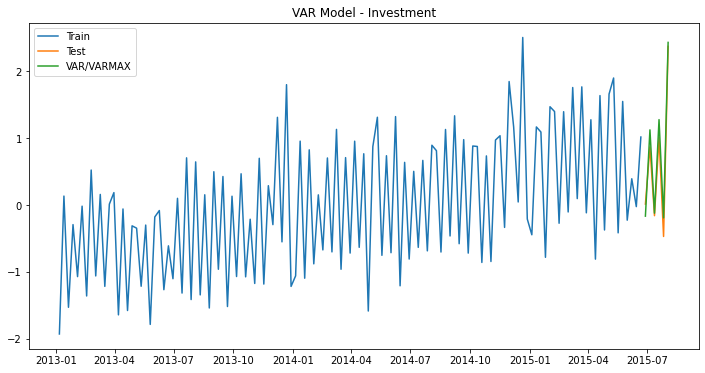

In [221]:
show_testVsPred_plot(store29_train['Sales_std'], store29_test['Sales_std'], predictions_store29['Sales_std'])

In [222]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store29_test['Sales_std'], predictions_store29['Sales_std']))
print(rmse)

0.20430305443333074


In [223]:
#converting standardized values back to orignal form
actual_store29 = pd.DataFrame(scaler_store29.inverse_transform(store29_test[['Sales_std', 'Customers_std']]))[0]
predicted_store29 = pd.DataFrame(scaler_store29.inverse_transform(predictions_store29[['Sales_std', 'Customers_std']]))[0]

#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store29, predicted_store29], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual    Predicted
0  5976.571429  5743.387677
1  7080.785714  7410.962340
2  5752.285714  5800.499126
3  7265.000000  7608.832652
4  5351.000000  5710.711086
5  9024.600000  9101.326726

In [224]:
sqrt(mean_squared_error(actual_store29,predicted_store29))

264.32799955803665

In [225]:
#MAPE value without 0 sales values
mape_store29 = mean_absolute_percentage_error(actual_store29, predicted_store29)
print(mape_store29)

3.61800398567114


In [226]:
final_results = final_results.append({'Store':'Store29', 'MAPE':mape_store29},ignore_index=True)
final_results

Store       MAPE
0   Store1   9.482873
1   Store3   8.148553
2   Store8  14.954222
3   Store9   2.385221
4  Store13  13.201332
5  Store25   9.623493
6  Store29   3.618004

## Result Analysis:-
     - For this store, I have predicted Sales for the next 6 weeks as required.

# Store 31 Analysis and Prediction

In [227]:
#Get store specific data
df_store31 = data_df[data_df['Store']==31]
df_store31 = df_store31.sort_index()

df_store31.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01     31          2      0          0     0      0              1   
2013-01-02     31          3   5122        567     1      0              1   
2013-01-03     31          4   5623        578     1      0              1   
2013-01-04     31          5   6140        633     1      0              1   
2013-01-05     31          6   5607        624     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

### Outliers Treatment

- Values beyond 99.9% percentiles shall be made nan and then linearly interpolated

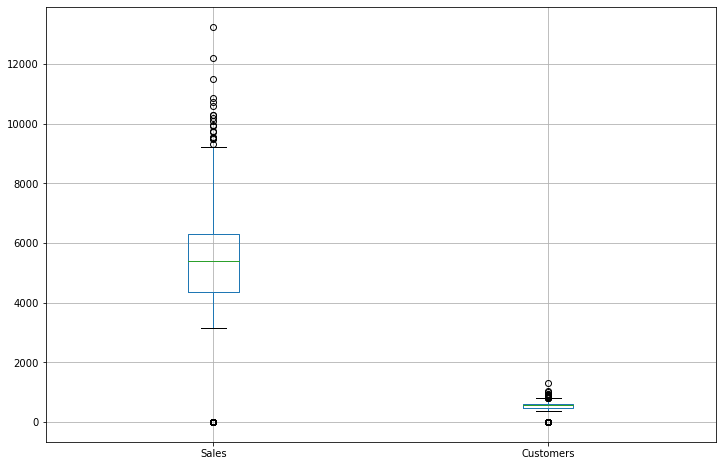

In [228]:
df_store31[['Sales', 'Customers']].boxplot()

In [229]:
df_store31.shape

(942, 12)

In [230]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store31, outlier_rows = make_outliers_nan(df_store31)

#We assigned NaN to all the outlier, 8 values of Sales
df_store31.loc[outlier_rows][['Sales', 'Customers']]

df_store31.interpolate(method='linear', inplace=True)

df_store31.isna().sum()

(942, 12)


Store                     0
DayOfWeek                 0
Sales                     0
Customers                 0
Open                      0
Promo                     0
SchoolHoliday             0
StateHoliday_Christmas    0
StateHoliday_Easter       0
StateHoliday_None         0
StateHoliday_Public       0
Holiday_Sunday            0
dtype: int64

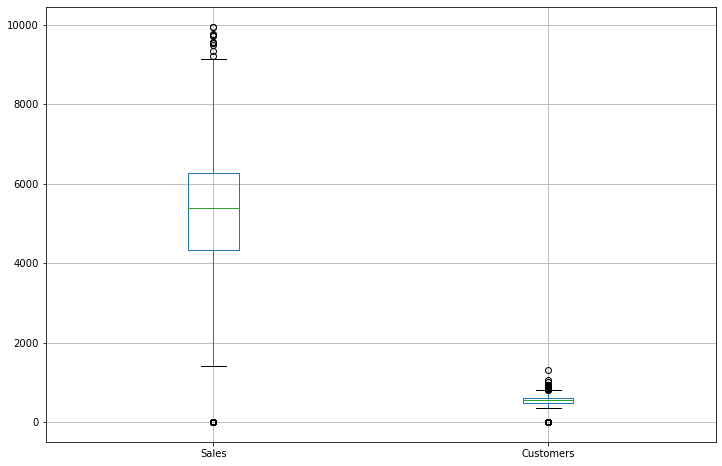

In [231]:
df_store31[['Sales', 'Customers']].boxplot()

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

In [232]:
#splitting data for training model to predict future values. I have taken apart 10 values to test the model
nobs = 42
store31_train, store31_test = data_split(nobs, df_store31)

#Standardizing data before modelling
store31_train[['Sales_std', 'Customers_std']], store31_test[['Sales_std', 'Customers_std']], scaler_store31 = data_standardization(store31_train[['Sales', 'Customers']], store31_test[['Sales', 'Customers']])

(900, 12)
(42, 12)


In [233]:
store31_train.head()

Store  DayOfWeek   Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                          
2013-01-01     31          2     0.0          0     0      0              1   
2013-01-02     31          3  5122.0        567     1      0              1   
2013-01-03     31          4  5623.0        578     1      0              1   
2013-01-04     31          5  6140.0        633     1      0              1   
2013-01-05     31          6  5607.0        624     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  Sales_std  Customers_std  
Date                                                                       
2013-01-01                    1               0  -1.967579      -2.075123  
2013-01-02                    0               0   0.127219       0.332872  
2013-01-03                    0               0   0.332118       0.379588  
2013-01-04                    0               0   0.543561       0.613168  
2013-01-05                    0               0   0.325574       0.574946

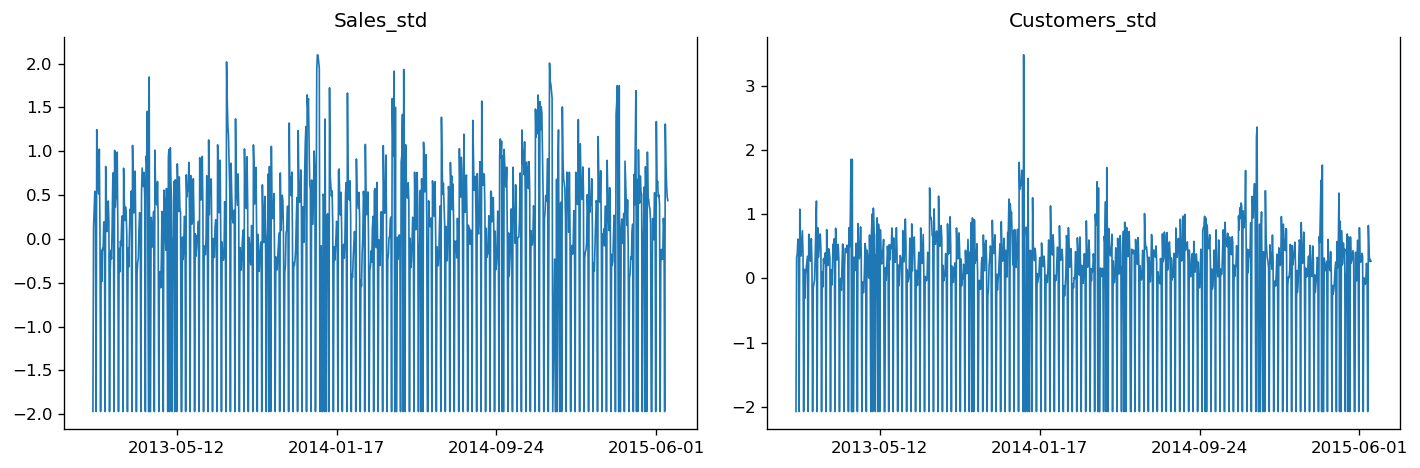

In [234]:
# Plot
ls=['Sales_std','Customers_std']
df=store31_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,4))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # Decorations
        ax.set_title(df.columns[i])
        ax.spines["top"].set_alpha(0)
        
plt.tight_layout();

In [235]:
# ADF Test on each column
for name, column in store31_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4741
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0277
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




### Both Sales and Customers are stationary so we can use VARMAX 

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

In [236]:
exog = store31_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,7]:
    for j in [1,7]:
        mod = VARMAX(store31_train[['Sales_std', 'Customers_std']], order=(i,j),trend='n', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model

Lag Order = 1 1
AIC :  632.1020495793948
BIC :  752.1619186625026
HQIC:  677.9657856424692 

Lag Order = 1 7
AIC :  457.15790595528824
BIC :  692.4752493581796
HQIC:  547.050828638914 

Lag Order = 7 1
AIC :  451.7569109145917
BIC :  687.0742543174829
HQIC:  541.6498335982174 

Lag Order = 7 7
AIC :  323.773466777842
BIC :  674.3482845005167
HQIC:  457.6955760820191 



In [237]:
exog = store31_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod = VARMAX(store31_train[['Sales_std', 'Customers_std']], order=(7,7),trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)

exog = store31_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions = res.forecast(steps= 42, exog=exog)
predictions.index = store31_test.index
predictions.head()

Sales_std  Customers_std
Date                                
2015-06-20   0.073299       0.313802
2015-06-21  -2.199963      -2.196589
2015-06-22  -0.000166       0.194956
2015-06-23  -0.149578      -0.095174
2015-06-24  -0.152161      -0.076138

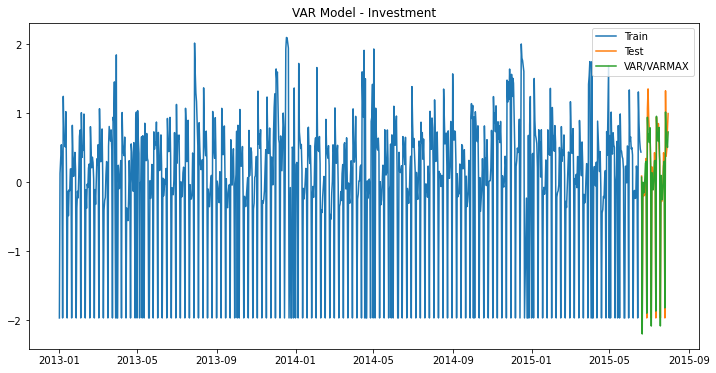

In [238]:
show_testVsPred_plot(store31_train['Sales_std'], store31_test['Sales_std'], predictions['Sales_std'])

In [239]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store31_test['Sales_std'], predictions['Sales_std']))
print(rmse)

0.19434931024077237


In [240]:
#converting standardized values back to orignal form
actual_store31 = pd.DataFrame(scaler_store31.inverse_transform(store31_test[['Sales_std', 'Customers_std']]))[0]
predicted_store31 = pd.DataFrame(scaler_store31.inverse_transform(predictions[['Sales_std', 'Customers_std']]))[0]

#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store31, predicted_store31], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)

Actual    Predicted
0  5032.0  4990.160499
1     0.0  -568.202428
2  4779.0  4810.531242
3  4327.0  4445.202273
4  4338.0  4438.886150
5  4370.0  4921.770311
6  4487.0  5489.888653
7  5656.0  5548.046651
8     0.0   169.971606
9  7416.0  7114.800300

In [241]:
sqrt(mean_squared_error(actual_store31,predicted_store31))

475.2043612859427

In [242]:
#MAPE value without 0 sales values
mape_store31 = mean_absolute_percentage_error(actual_store31, predicted_store31)
print(mape_store31)

6.1541519808943255


In [243]:
final_results = final_results.append({'Store':'Store31', 'MAPE':mape_store31},ignore_index=True)
final_results

Store       MAPE
0   Store1   9.482873
1   Store3   8.148553
2   Store8  14.954222
3   Store9   2.385221
4  Store13  13.201332
5  Store25   9.623493
6  Store29   3.618004
7  Store31   6.154152

## Result Analysis:-
    - We can see that from the predicted vs Actual values that the predicted values came out to be very close to each other. The rows where actual Sales were 0, our model has predicted a value close to 0
    - We can consider low values of Sales as an indictor that there will be close to none, i.e., 0 sales on that particular day
    - For this store, I have predicted Sales for the next 42 days which is 6 weeks prediction as required.

# Store 46 Analysis

In [244]:
df_store46 = data_df[data_df['Store']==46]
df_store46 = df_store46.sort_index()

df_store46.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01     46          2      0          0     0      0              1   
2013-01-02     46          3   4016        582     1      0              1   
2013-01-03     46          4   4177        553     1      0              1   
2013-01-04     46          5   4125        569     1      0              1   
2013-01-05     46          6   4848        651     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

In [245]:
#dataset has many missing values. It should have 942 rows but have only 758 means 184 rows are missing
df_store46.shape

(758, 12)

In [246]:
#checking dates not present between '2013-01-01' and '31-07-2015'
#so we have 184 missing rows
len(pd.to_datetime([date for date in pd.date_range(start ='2013-01-01', 
         end ='31-07-2015') if date not in df_store46.index],format="%Y-%m-%d"))

184

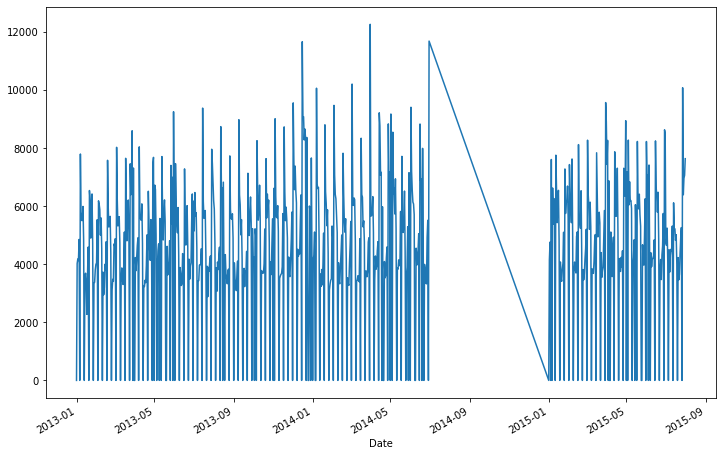

In [247]:
#trying to do the linear interpolation of the missing values.
df_store46.interpolate(method='time', inplace=False)['Sales'].plot()

### We see that linear interpolation doesn't work bad that good so we will use a VARMAX model to predict the missing data from the available data.

In [248]:
#we don't have any missing values in the available data
df_store46.isna().sum()

Store                     0
DayOfWeek                 0
Sales                     0
Customers                 0
Open                      0
Promo                     0
SchoolHoliday             0
StateHoliday_Christmas    0
StateHoliday_Easter       0
StateHoliday_None         0
StateHoliday_Public       0
Holiday_Sunday            0
dtype: int64

### Outliers Treatment
- Values beyond 99.9% percentiles shall be removed

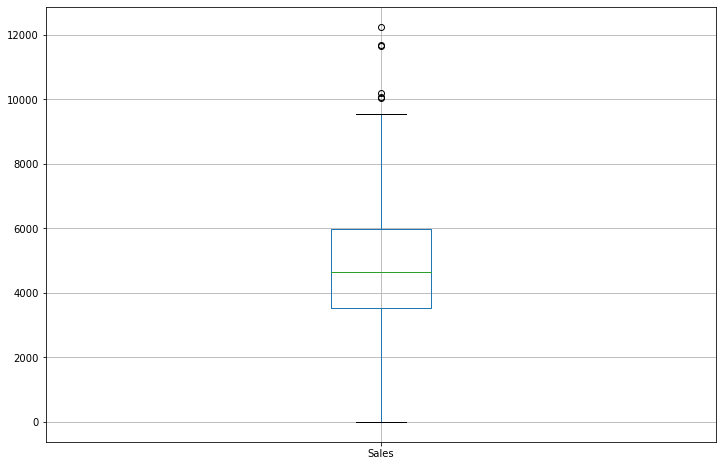

In [249]:
df_store46[['Sales']].boxplot()

In [250]:
#Making outliers NaN instead of removing them. We will interpolate the values later
df_store46, outlier_rows = make_outliers_nan(df_store46)

#We assigned NaN to all the outlier, 8 values of Sales
df_store46.loc[outlier_rows][['Sales', 'Customers']]

(758, 12)


Sales  Customers
Date                        
2013-12-02    NaN        943
2013-12-16    NaN       1076
2014-01-07    NaN       1035
2014-03-03    NaN        940
2014-03-31    NaN       1029
2014-06-30    NaN       1092
2015-03-30    NaN        882
2015-07-27    NaN        896

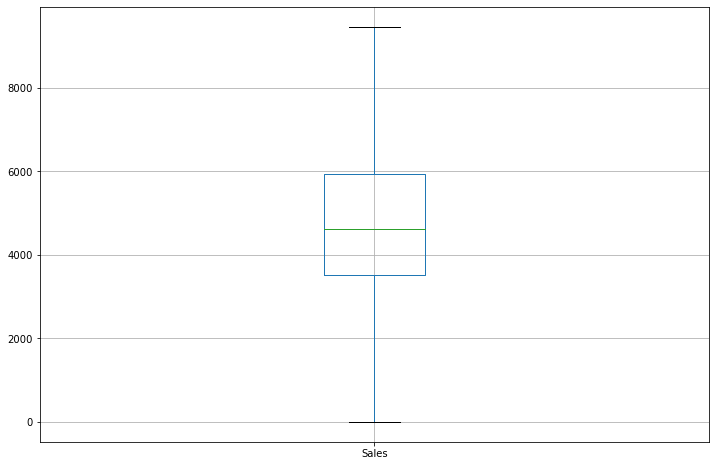

In [251]:
df_store46[['Sales']].boxplot()

In [252]:
#adding missing dates to the store dataframe. All the values in all columns are assigned Nan
for date in pd.to_datetime([date for date in pd.date_range(start ='2013-01-01', 
         end ='31-07-2015') if date not in df_store46.index],format="%Y-%m-%d"):
    df_store46.loc[date] = np.nan
#The data now has all the dates
print(df_store46.shape)

(942, 12)


In [253]:
#Getting the missing dates
missing_dates = df_store46[df_store46['StateHoliday_Easter'].isna()].index

In [254]:
#Now we want to add values to all the columns other than Sales and Customers. Here, I am using data from another
#store 440 which has the same store type, assortment, promo etc values as Store 13. 
#Also, columns like SchoolHolidays, DayOfWeek, Sundays etc are gonna remain the same
df_store440 = data_df[data_df['Store']==440]
df_store440 = df_store440.sort_index()

df_store440.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                         
2013-01-01    440          2      0          0     0      0              1   
2013-01-02    440          3   4503        596     1      0              1   
2013-01-03    440          4   4187        550     1      0              1   
2013-01-04    440          5   4445        553     1      0              1   
2013-01-05    440          6   3172        362     1      0              0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                       0                    0                  0   
2013-01-02                       0                    0                  1   
2013-01-03                       0                    0                  1   
2013-01-04                       0                    0                  1   
2013-01-05                       0                    0                  1   

            StateHoliday_Public  Holiday_Sunday  
Date                                             
2013-01-01                    1               0  
2013-01-02                    0               0  
2013-01-03                    0               0  
2013-01-04                    0               0  
2013-01-05                    0               0

In [255]:
#Assigning data from store 440 to Store 46
df_store46.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), :] = df_store440.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), :].values
df_store46 = df_store46.sort_index()
df_store46.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31'))].head()

Store  DayOfWeek   Sales  Customers  Open  Promo  SchoolHoliday  \
2014-07-01  440.0        2.0  6995.0      733.0   1.0    1.0            0.0   
2014-07-02  440.0        3.0  5813.0      650.0   1.0    1.0            0.0   
2014-07-03  440.0        4.0  5959.0      666.0   1.0    1.0            0.0   
2014-07-04  440.0        5.0  5791.0      671.0   1.0    1.0            0.0   
2014-07-05  440.0        6.0  3662.0      389.0   1.0    0.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
2014-07-01                     0.0                  0.0                1.0   
2014-07-02                     0.0                  0.0                1.0   
2014-07-03                     0.0                  0.0                1.0   
2014-07-04                     0.0                  0.0                1.0   
2014-07-05                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  
2014-07-01                  0.0             0.0  
2014-07-02                  0.0             0.0  
2014-07-03                  0.0             0.0  
2014-07-04                  0.0             0.0  
2014-07-05                  0.0             0.0

In [256]:
#Assigning NaN to Sales and Customers because those values are from Store 440 
#Assigning Store id = 46 to all 440 store ids
df_store46.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), ['Sales', 'Customers']] = np.nan
df_store46.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), ['Store']] = 46
df_store46.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31'))].head()

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
2014-07-01   46.0        2.0    NaN        NaN   1.0    1.0            0.0   
2014-07-02   46.0        3.0    NaN        NaN   1.0    1.0            0.0   
2014-07-03   46.0        4.0    NaN        NaN   1.0    1.0            0.0   
2014-07-04   46.0        5.0    NaN        NaN   1.0    1.0            0.0   
2014-07-05   46.0        6.0    NaN        NaN   1.0    0.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
2014-07-01                     0.0                  0.0                1.0   
2014-07-02                     0.0                  0.0                1.0   
2014-07-03                     0.0                  0.0                1.0   
2014-07-04                     0.0                  0.0                1.0   
2014-07-05                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  
2014-07-01                  0.0             0.0  
2014-07-02                  0.0             0.0  
2014-07-03                  0.0             0.0  
2014-07-04                  0.0             0.0  
2014-07-05                  0.0             0.0

In [257]:
#Preparing interpolation data. We are using data from dates '2013-01-01' to '2014-06-29' to predict missing data
interp_data = df_store46.loc[pd.to_datetime([date for date in pd.date_range(start ='2013-01-01', 
         end ='2014-06-29')])]
print(interp_data.shape)

(545, 12)


In [258]:
#We have few Nan values generated because of outliers removal. we want to interpolate using simple linear
#interpolation
interp_data[interp_data['Sales'].isna()]

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
2013-12-02   46.0        1.0    NaN      943.0   1.0    1.0            0.0   
2013-12-16   46.0        1.0    NaN     1076.0   1.0    1.0            0.0   
2014-01-07   46.0        2.0    NaN     1035.0   1.0    1.0            0.0   
2014-03-03   46.0        1.0    NaN      940.0   1.0    1.0            1.0   
2014-03-31   46.0        1.0    NaN     1029.0   1.0    1.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
2013-12-02                     0.0                  0.0                1.0   
2013-12-16                     0.0                  0.0                1.0   
2014-01-07                     0.0                  0.0                1.0   
2014-03-03                     0.0                  0.0                1.0   
2014-03-31                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  
2013-12-02                  0.0             0.0  
2013-12-16                  0.0             0.0  
2014-01-07                  0.0             0.0  
2014-03-03                  0.0             0.0  
2014-03-31                  0.0             0.0

In [259]:
#using linear interpolation to finalize train data
interp_data.interpolate(method='linear', inplace=True)

#splitting data for training model to predict future values. I have taken apart 10 values to test the model
interp_train_data, interp_test_data = data_split(10, interp_data)

#Standardizing data before modelling
intp_train = interp_train_data.copy()
intp_test = interp_test_data.copy()
intp_train[['Sales', 'Customers']], intp_test[['Sales', 'Customers']], scaler_intp = data_standardization(interp_train_data[['Sales', 'Customers']], interp_test_data[['Sales', 'Customers']])

(535, 12)
(10, 12)


In [260]:
# ADF Test on each column
for name, column in intp_train[['Sales', 'Customers']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

### Both Sales and Customers are stationary so we can use VARMAX 

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5971
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9976
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [261]:
exog_intp = intp_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_intp = VARMAX(intp_train[['Sales', 'Customers']], order=(7,7),trend='n', exog=exog_intp)
results_intp = mod_intp.fit(maxiter=1000, disp=False)

exog_intp = intp_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_intp = results_intp.forecast(10, exog=exog_intp)
predictions_intp.index = intp_test.index
predictions_intp.head()

Sales  Customers
2014-06-20  1.110039   1.103780
2014-06-21  0.116413   0.343411
2014-06-22 -1.721287  -1.930721
2014-06-23 -0.002307   0.152633
2014-06-24 -0.163543   0.045582

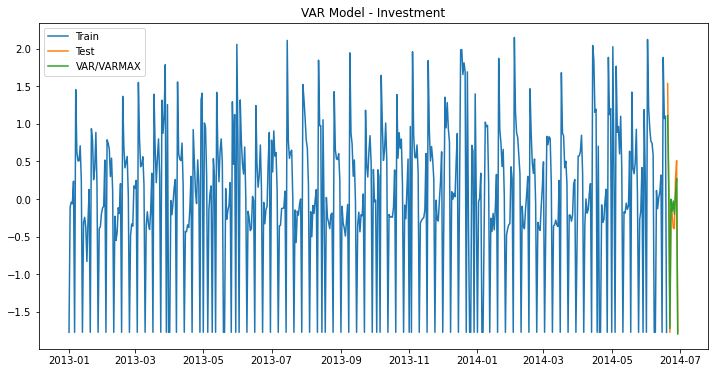

In [262]:
show_testVsPred_plot(intp_train['Sales'], intp_test['Sales'], predictions_intp['Sales'])

### we can see from the plot that our model predicted the test values acceptably alright. So, we now will use the complete train data and predict missing 184 Sales and Customers values

In [263]:
#Standardizing final training data for interpolation
intp_final_train, intp_final_test, scaler_intp = data_standardization(interp_data[['Sales', 'Customers']], interp_data[['Sales', 'Customers']])

intp_final_train.shape

(545, 2)

In [264]:
exog_intp_final = interp_data[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod_intp_final = VARMAX(intp_final_train, order=(7,7),trend='n', exog=exog_intp_final)
results_intp_final = mod_intp_final.fit(maxiter=1000, disp=False)
exog_intp_final = df_store46.loc[missing_dates][['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions_intp_final = results_intp_final.forecast(184, exog=exog_intp_final)
predictions_intp_final.index = missing_dates
predictions_intp_final.columns=['Sales', 'Customers']
predictions_intp_final.head()

Sales  Customers
Date                           
2014-07-01  1.279088   1.123746
2014-07-02  0.808610   0.660382
2014-07-03  0.721991   0.611865
2014-07-04  0.735644   0.615423
2014-07-05  0.061627   0.295401

In [265]:
interp_data[['Sales_std', 'Customers_std']] = intp_final_train 

interp_data[['Sales_std', 'Customers_std']].head()

Sales_std  Customers_std
2013-01-01  -1.769234      -1.954593
2013-01-02  -0.103766       0.144066
2013-01-03  -0.036998       0.039493
2013-01-04  -0.058563       0.097188
2013-01-05   0.241271       0.392876

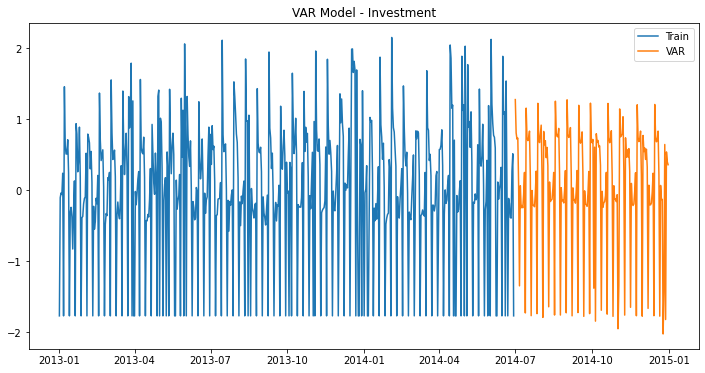

In [266]:
plt.figure(figsize=(12,6))
plt.plot(interp_data[['Sales_std']], label='Train')
plt.plot(predictions_intp_final['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Investment')
plt.show()

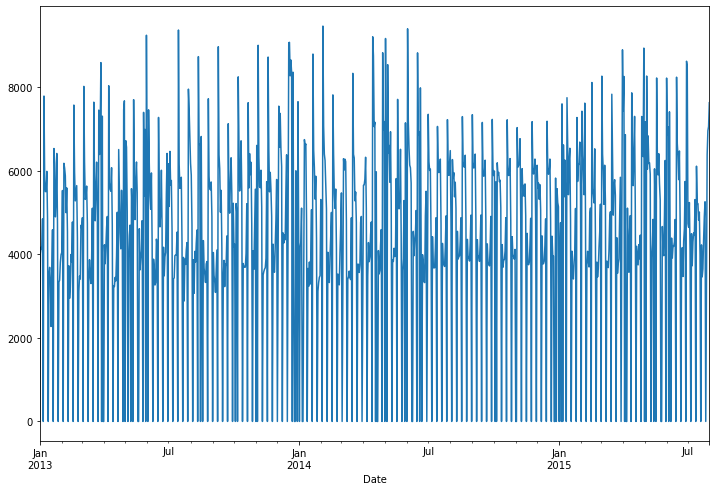

In [267]:
#above graph looks fine. we will now transform the values to original scale
#preparing final interpolated dataset
interpolated_data_original_scale = scaler_intp.inverse_transform(predictions_intp_final)
df_store46.loc[pd.to_datetime(pd.date_range(start ='2014-07-01', end ='2014-12-31')), ['Sales', 'Customers']] = interpolated_data_original_scale
df_store46.interpolate(method='linear', inplace=True)
df_store46.loc[df_store46[(df_store46['Open']==0) & (df_store46['Sales']!=0)].index, ['Sales', 'Customers']] = 0

df_store46['Sales'].plot()

### Building model to predict Sales

- First preprocess the store specific data
- Check stationarity 
- Build Model

In [268]:
df_store46 = df_store46.sort_index()
#splitting data for training model to predict future values
nobs = 42
store46_train, store46_test = data_split(nobs, df_store46)

#Standardizing final training data for interpolation
store46_train[['Sales_std', 'Customers_std']], store46_test[['Sales_std', 'Customers_std']], scaler_store46 = data_standardization(store46_train[['Sales', 'Customers']], store46_test[['Sales', 'Customers']])

store46_train.head()

(900, 12)
(42, 12)


Store  DayOfWeek   Sales  Customers  Open  Promo  SchoolHoliday  \
Date                                                                          
2013-01-01   46.0        2.0     0.0        0.0   0.0    0.0            1.0   
2013-01-02   46.0        3.0  4016.0      582.0   1.0    0.0            1.0   
2013-01-03   46.0        4.0  4177.0      553.0   1.0    0.0            1.0   
2013-01-04   46.0        5.0  4125.0      569.0   1.0    0.0            1.0   
2013-01-05   46.0        6.0  4848.0      651.0   1.0    0.0            0.0   

            StateHoliday_Christmas  StateHoliday_Easter  StateHoliday_None  \
Date                                                                         
2013-01-01                     0.0                  0.0                0.0   
2013-01-02                     0.0                  0.0                1.0   
2013-01-03                     0.0                  0.0                1.0   
2013-01-04                     0.0                  0.0                1.0   
2013-01-05                     0.0                  0.0                1.0   

            StateHoliday_Public  Holiday_Sunday  Sales_std  Customers_std  
Date                                                                       
2013-01-01                  1.0             0.0  -1.820068      -1.988525  
2013-01-02                  0.0             0.0  -0.131330       0.139682  
2013-01-03                  0.0             0.0  -0.063629       0.033637  
2013-01-04                  0.0             0.0  -0.085495       0.092145  
2013-01-05                  0.0             0.0   0.218528       0.391995

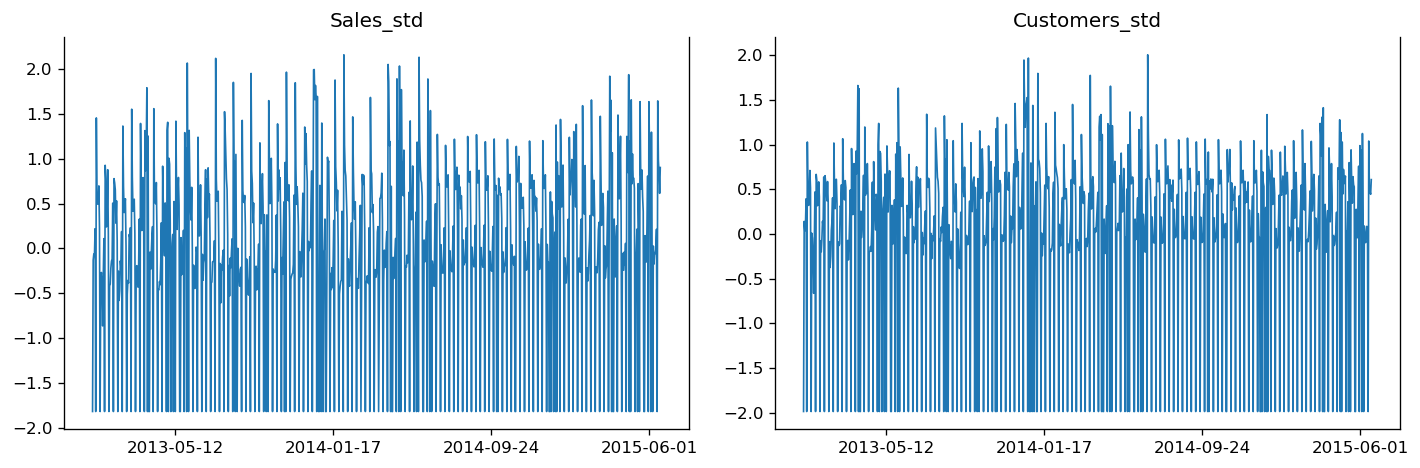

In [269]:
# Plot
ls=['Sales_std','Customers_std']
df=store46_train[ls]
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,4))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # Decorations
        ax.set_title(df.columns[i])
        ax.spines["top"].set_alpha(0)
        
plt.tight_layout();

In [270]:
# ADF Test on each column
for name, column in store46_train[['Sales_std', 'Customers_std']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1347
 No. Lags Chosen       = 21
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers_std" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0119
 No. Lags Chosen       = 20
 Critical value 1%     = -3.438
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




### Since both Sales ans Customers are stationary, we can build VARMAX model

In [271]:
exog = store46_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]

for i in [1,7]:
    for j in [1,7]:
        mod = VARMAX(store46_train[['Sales_std', 'Customers_std']], order=(i,j),trend='n', exog=exog)
        res = mod.fit(maxiter=1000, disp=False)
        print('Lag Order =', i,j)
        print('AIC : ', res.aic)
        print('BIC : ', res.bic)
        print('HQIC: ', res.hqic, '\n')

#Note the AIC value - lower AIC => better model 

Lag Order = 1 1
AIC :  226.70199310639316
BIC :  346.7618621895009
HQIC:  272.56572916946755 

Lag Order = 1 7
AIC :  184.23855231594018
BIC :  419.55589571883144
HQIC:  274.1314749995659 

Lag Order = 7 1
AIC :  33.1401167022359
BIC :  268.45746010512715
HQIC:  123.03303938586163 

Lag Order = 7 7
AIC :  -141.4950513034388
BIC :  209.0797664192359
HQIC:  -7.572941999261673 



In [272]:
#Building model after considering hyperparameter values we got from previous step
exog = store46_train[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
mod = VARMAX(store46_train[['Sales_std', 'Customers_std']], order=(7,7),trend='c', exog=exog)
res = mod.fit(maxiter=1000, disp=False)

exog = store46_test[['Promo','SchoolHoliday','StateHoliday_Christmas','StateHoliday_Easter',
                     'StateHoliday_None', 'StateHoliday_Public', 'Holiday_Sunday']]
predictions = res.forecast(steps= 42, exog=exog)
predictions.index = store46_test.index
predictions.head()

Sales_std  Customers_std
Date                                
2015-06-20   0.152549       0.375261
2015-06-21  -1.793047      -1.998802
2015-06-22  -0.084556       0.093678
2015-06-23  -0.285414      -0.089708
2015-06-24  -0.192069      -0.076914

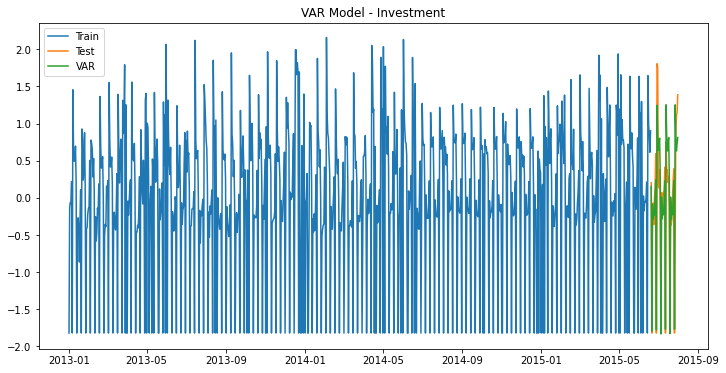

In [273]:
plt.figure(figsize=(12,6))
plt.plot(store46_train[['Sales_std']], label='Train')
plt.plot(store46_test[['Sales_std']], label='Test')
plt.plot(predictions['Sales_std'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Investment')
plt.show()

In [274]:
#we are only using rmse not mape to assess the performance of the model as the time series has 0 values
#and mape values will be thus infinity all the time
rmse = sqrt(mean_squared_error(store46_test['Sales_std'], predictions['Sales_std']))
print(rmse)

0.4276581151747515


In [275]:
#converting standardized values back to orignal form
actual_store46 = pd.DataFrame(scaler_store46.inverse_transform(store46_test[['Sales_std', 'Customers_std']]))[0]
predicted_store46 = pd.DataFrame(scaler_store46.inverse_transform(predictions[['Sales_std', 'Customers_std']]))[0]

#lets check the original values predicted vs actual
compare_act_pred = pd.concat([actual_store46, predicted_store46], axis=1)
compare_act_pred.columns = ['Actual', 'Predicted']
compare_act_pred.head(10)


Actual    Predicted
0  4812.0  4691.093382
1     0.0    64.258251
2  3792.0  4127.233178
3  4160.0  3649.571045
4  3469.0  3871.556553
5  4319.0  3774.161355
6  4618.0  4378.242865
7  5743.0  4904.287316
8     0.0    96.411010
9  8621.0  7290.653109

In [276]:
sqrt(mean_squared_error(actual_store46,predicted_store46))

1017.016983216378

In [277]:
#MAPE value without 0 sales values
mape_store46 = mean_absolute_percentage_error(actual_store46, predicted_store46)
print(mape_store46)

16.641840665674206


In [278]:
final_results = final_results.append({'Store':'Store46', 'MAPE':mape_store46},ignore_index=True)
final_results

Store       MAPE
0   Store1   9.482873
1   Store3   8.148553
2   Store8  14.954222
3   Store9   2.385221
4  Store13  13.201332
5  Store25   9.623493
6  Store29   3.618004
7  Store31   6.154152
8  Store46  16.641841

## Result Analysis:-
    - We can see that from the predicted vs Actual values that the predicted values came out to be very close to each other. The rows where actual Sales were 0, our model has predicted a value close to 0
    - We can consider low values of Sales as an indictor that there will be close to none, i.e., 0 sales on that particular day
    - For this store, I have predicted Sales for the next 42 days which is 6 weeks prediction as required.

# Final MAPE value results for all stores:-

In [279]:
final_results

Store       MAPE
0   Store1   9.482873
1   Store3   8.148553
2   Store8  14.954222
3   Store9   2.385221
4  Store13  13.201332
5  Store25   9.623493
6  Store29   3.618004
7  Store31   6.154152
8  Store46  16.641841

# Conclusion

1. Store 1:-
    - Daily data was considered 
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series are Stationary
    - Since both series are stationary, we didn't have to check about cointegration
    - Since both series are already stationary, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 42 days, i.e., 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built
    
2. Store 3:-
    - Daily data was considered 
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series are Stationary
    - Since both series are stationary, we didn't have to check about cointegration
    - Since both series are already stationary, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 42 days, i.e., 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built
    
3. Store 8:-
    - Daily data was considered 
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series are Stationary
    - Since both series are stationary, we didn't have to check about cointegration
    - Since both series are already stationary, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 42 days, i.e., 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built
    
4. Store 9:-
    - Daily was resampled to weekly data.So, weekly data was considered 
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series came out to be Non-Stationary
    - Since both series came out to be non-stationary, we checked for cointegration using both Johansen and Granger's cointegration test and both came out to be cointegrated with each other.
    - Since both series are conintegrated, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built
    
5. Store 13:-
    - Daily data was considered 
    - 6 months data was missing. Previously available data was used to predict and the interpolate the missing 6 months data.  
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series are Stationary
    - Since both series are stationary, we didn't have to check about cointegration
    - Since both series are already stationary, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 42 days, i.e., 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built
    
6. Store 25:-
    - Daily data was considered 
    - 30 days data was missing. Previously available data was used to predict and the interpolate the missing 30 days data.  
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series are Stationary
    - Since both series are stationary, we didn't have to check about cointegration
    - Since both series are already stationary, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 42 days, i.e., 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built
    
7. Store 29:-
    - Daily was resampled to weekly data.So, weekly data was considered 
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series came out to be Non-Stationary
    - Since both series came out to be non-stationary, we checked for cointegration using both Johansen and Granger's cointegration test and both came out to be cointegrated with each other.
    - Since both series are conintegrated, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built

    
8. Store 31:-
    - Daily data was considered 
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series are Stationary
    - Since both series are stationary, we didn't have to check about cointegration
    - Since both series are already stationary, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 42 days, i.e., 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built

5. Store 46:-
    - Daily data was considered 
    - 6 months data was missing. Previously available data was used to predict and the interpolate the missing 6 months data.  
    - Outliers were made NaN and then linearly interpolated
    - Both Sales and Customers endogenous time series are Stationary
    - Since both series are stationary, we didn't have to check about cointegration
    - Since both series are already stationary, we didn't perform any differencing or boxcox transformation
    - VARMAX model was tuned and built using endogenous variable Sales and Customers and exogenous variables:-
      Promo,SchoolHoliday,StateHoliday_Christmas,StateHoliday_Easter,StateHoliday_None,StateHoliday_Public, Holiday_Sunday                
    - Prediction was done for the next 42 days, i.e., 6 weeks
    - Graph comparing TRAIN, TEST and VAR/VARMAX predicted 
    - RMSE value was calculated for both standardized and actual values
    - Dataframe comparing actual TEST and PREDICTED values was built
    
### Few take away points:-
- Resampled weekly data was used for stores 9 and 29. For of the stores, daily data was used. 
- For stores with missing data, previous data was used to build a VARMAX model and use its predictions to interpolate missing data
- MAPE was calculated without considering 0 Sales records in actual data